# Feature elimination

In [187]:
import sys
sys.path.insert(0, '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing')
from dp_utils import *
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
data_path = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/EQs/EQ_3.h5'
df = pd.read_hdf(data_path, key = 'table')
df.columns = ['s','ttf']

In [188]:
config_path = "/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_config.json"
with open(config_path, 'rb') as config:
    params = json.load(config)

routines = params['routines']
default_window_size = params['window_size']
new_df = process_df(df, routines,default_window_size)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_config.json'

In [13]:
save_to = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/featurized_data_EQ_3.h5'
new_df.to_hdf(save_to, key = 'table')

Preparing the data

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = new_df.loc[:, new_df.columns != 'ttf']
X = np.array(X)
scaler.fit(X)
X = scaler.transform(X)
y = np.array(new_df.ttf)

# Removing features with low variance

In [15]:
from sklearn.feature_selection import VarianceThreshold
print("было: ",len(new_df.columns))
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected_features = sel.fit_transform(new_df)
print("стало: ",selected_features.shape[1])

было:  8
стало:  6


# Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.

**SelectKBest** removes all but the  highest scoring features.

The methods based on **F-test** estimate the degree of linear dependency between two random variables. On the other hand, **mutual information** methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

In [19]:
from sklearn.feature_selection import SelectKBest,SelectFpr, SelectFdr
from sklearn.feature_selection import f_regression, mutual_info_regression
X_new = SelectKBest(mutual_info_regression, k=3).fit_transform(X, y)
print(X_new.shape)

(4443, 3)


**SelectFpr**

Filter: Select the pvalues below alpha based on a FPR test.

FPR test stands for False Positive Rate test. It controls the total amount of false detections.

In [20]:
X_new = SelectFpr(f_regression,alpha = 0.1).fit_transform(X, y)
print(X_new.shape)

(4443, 5)


/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:560: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha


**SelectFdr**

Filter: Select the p-values for an estimated false discovery rate

This uses the Benjamini-Hochberg procedure. alpha is an upper bound on the expected false discovery rate.

In [21]:
X_new = SelectFdr(f_regression,alpha = 0.1).fit_transform(X, y)
print(X_new.shape)

(4443, 5)


/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:619: RuntimeWarning: invalid value encountered in less_equal
  np.arange(1, n_features + 1)]
/home/pavel/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:622: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()


# Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (**RFE**) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [22]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

In [9]:
estimator = DTR()
selector = RFE(estimator, 3, step=1)

selector = selector.fit(X, y)
print(selector.support_) 
print("Remaining features: ")
print([col for indicator, col in zip(selector.support_,list(new_df.columns)) if indicator == True])
print(selector.ranking_)

[ True  True False False False False  True]
Remaining features: 
['w_abs_energy(s, window_size=5000)', 'w_absolute_sum_of_changes(s, window_size=15000)', 'w_savgol_filter(w_psd(s, window_size=10000, fs=4000000.0), window_size=9999999999, window_length=201, polyorder=1)']
[1 1 2 5 3 4 1]


In [10]:
selector

RFE(estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
  n_features_to_select=3, step=1, verbose=0)

In [166]:
estimator = RFR()
selector = RFE(estimator, 3, step=1)

selector = selector.fit(X, y)
print(selector.support_) 
print("Remaining features: ")
print([col for indicator, col in zip(selector.support_,list(new_df.columns)) if indicator == True])
print(selector.ranking_)

[ True  True False False False False  True]
Remaining features: 
['w_abs_energy(df, window_size=5000)', 'w_absolute_sum_of_changes(df, window_size=15000)', 'w_savgol_filter(df, window_size=9999999999, window_length=201, polyorder=1)']
[1 1 3 5 2 4 1]


# L1-based feature selection

Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with feature_selection.SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the linear_model.Lasso for regression, and of linear_model.LogisticRegression and svm.LinearSVC for classification

In [161]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

print(X.shape)
regressor = Lasso(alpha = 0.0015, normalize = True).fit(X, y)
model = SelectFromModel(regressor, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(4443, 7)
(4443, 2)


# Tree-based feature selection

In [147]:
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

In [148]:
print(X.shape)
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
print(clf.feature_importances_)
X_new = model.transform(X)
print(X_new.shape)

(4443, 12)
[0.06001588 0.10434405 0.05755731 0.09323816 0.05097123 0.10392757
 0.05624428 0.20129047 0.04858997 0.04929882 0.11488981 0.05963245]
(4443, 5)


# Testing elimination strategies

In [ ]:
def load_dataset(list_of_EQs, path)

In [185]:
import sys
sys.path.insert(0, '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing')
from dp_features import *
from dp_utils import process_df
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle
import numpy as np
scaler = StandardScaler()
######################################################################################
data_path = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/EQs/EQ_2.h5'
df_EQ2 = pd.read_hdf(data_path, key = 'table')
df_EQ2.columns = ['s','ttf']

config_path = "/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/configs/dp_config.json"
with open(config_path, 'rb') as config:
    params = json.load(config)

routines = params['routines']
default_window_size = params['window_size']
df_EQ2 = process_df(df_EQ2, routines,default_window_size, df_path = '../data/test_EQ2')

X_EQ2 = df_EQ2.loc[:, df_EQ2.columns != 'ttf']
X_cols_EQ2 = list(X_EQ2.columns)
X_EQ2 = np.array(X_EQ2)
scaler.fit(X_EQ2)

X_EQ2 = scaler.transform(X_EQ2)
y_EQ2 = np.array(df_EQ2.ttf)

# X_EQ2, y_EQ2 = shuffle(X_EQ2, y_EQ2, random_state=np.random.randint(100))
######################################################################################
data_path = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/EQs/EQ_3.h5'
df_EQ3 = pd.read_hdf(data_path, key = 'table')
df_EQ3.columns = ['s','ttf']
config_path = "/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/configs/dp_config.json"
with open(config_path, 'rb') as config:
    params = json.load(config)

routines = params['routines']
default_window_size = params['window_size']
df_EQ3 = process_df(df_EQ3, routines,default_window_size, df_path = '../data/test_EQ3')

X_EQ3 = df_EQ3.loc[:, df_EQ3.columns != 'ttf']
X_cols_EQ3 = list(X_EQ3.columns)
X_EQ3 = np.array(X_EQ3)

X_EQ3 = scaler.transform(X_EQ3)
y_EQ3 = np.array(df_EQ3['ttf'])
# X_EQ3, y_EQ3 = shuffle(X_EQ3, y_EQ3, random_state=np.random.randint(100))
######################################################################################

/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_utils.py:143: UserWarning: Directory ../data/test_EQ2 already exists. Running data processing in this directory again might lead to data loss.
  warnings.warn(f"Directory {df_path} already exists. "


Calculation of 44 features...
File w_psd(s, window_size=10000, fs=4000000.0).h5 already exists. Skip calculations and append it to the dataframe
Feature w_periodogram calcualtion is disabled
File w_abs_energy(s, window_size=5000).h5 already exists. Skip calculations and append it to the dataframe
File w_absolute_sum_of_changes(s, window_size=15000).h5 already exists. Skip calculations and append it to the dataframe
Feature w_approximate_entropy calcualtion is disabled
File w_autocorrelation(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_autocorrelation(s, window_size=10000, lag=10).h5 already exists. Skip calculations and append it to the dataframe
File w_binned_entropy(s, window_size=10000, max_bins=10).h5 already exists. Skip calculations and append it to the dataframe
File w_c3(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_con(s, window_size=10000).h5 already exists

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing/dp_utils.py:143: UserWarning: Directory ../data/test_EQ3 already exists. Running data processing in this directory again might lead to data loss.
  warnings.warn(f"Directory {df_path} already exists. "


Calculation of 44 features...
File w_psd(s, window_size=10000, fs=4000000.0).h5 already exists. Skip calculations and append it to the dataframe
Feature w_periodogram calcualtion is disabled
File w_abs_energy(s, window_size=5000).h5 already exists. Skip calculations and append it to the dataframe
File w_absolute_sum_of_changes(s, window_size=15000).h5 already exists. Skip calculations and append it to the dataframe
Feature w_approximate_entropy calcualtion is disabled
File w_autocorrelation(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_autocorrelation(s, window_size=10000, lag=10).h5 already exists. Skip calculations and append it to the dataframe
File w_binned_entropy(s, window_size=10000, max_bins=10).h5 already exists. Skip calculations and append it to the dataframe
File w_c3(s, window_size=10000, lag=100).h5 already exists. Skip calculations and append it to the dataframe
File w_con(s, window_size=10000).h5 already exists

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [186]:
from sklearn.feature_selection import SelectKBest,SelectFpr, SelectFdr, SelectPercentile
from sklearn.feature_selection import f_regression, mutual_info_regression

def eliminate_features(eliminator, X, cols):
    inds_mask = eliminator.get_support()
    return X[:,inds_mask], np.array(cols)[inds_mask]

def get_feature_importance(selector, features):
    l = sorted(list(zip(list(selector.scores_), list(features))), key = lambda t: -t[0]) 
    return [el[0] for el in l], [el[1] for el in l]

selector_univariate = SelectPercentile(mutual_info_regression, percentile = 60).fit(X_EQ2, y_EQ2)
X_EQ2_u, X_cols_EQ2_u = eliminate_features(selector_univariate, X_EQ2, X_cols_EQ2)

/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


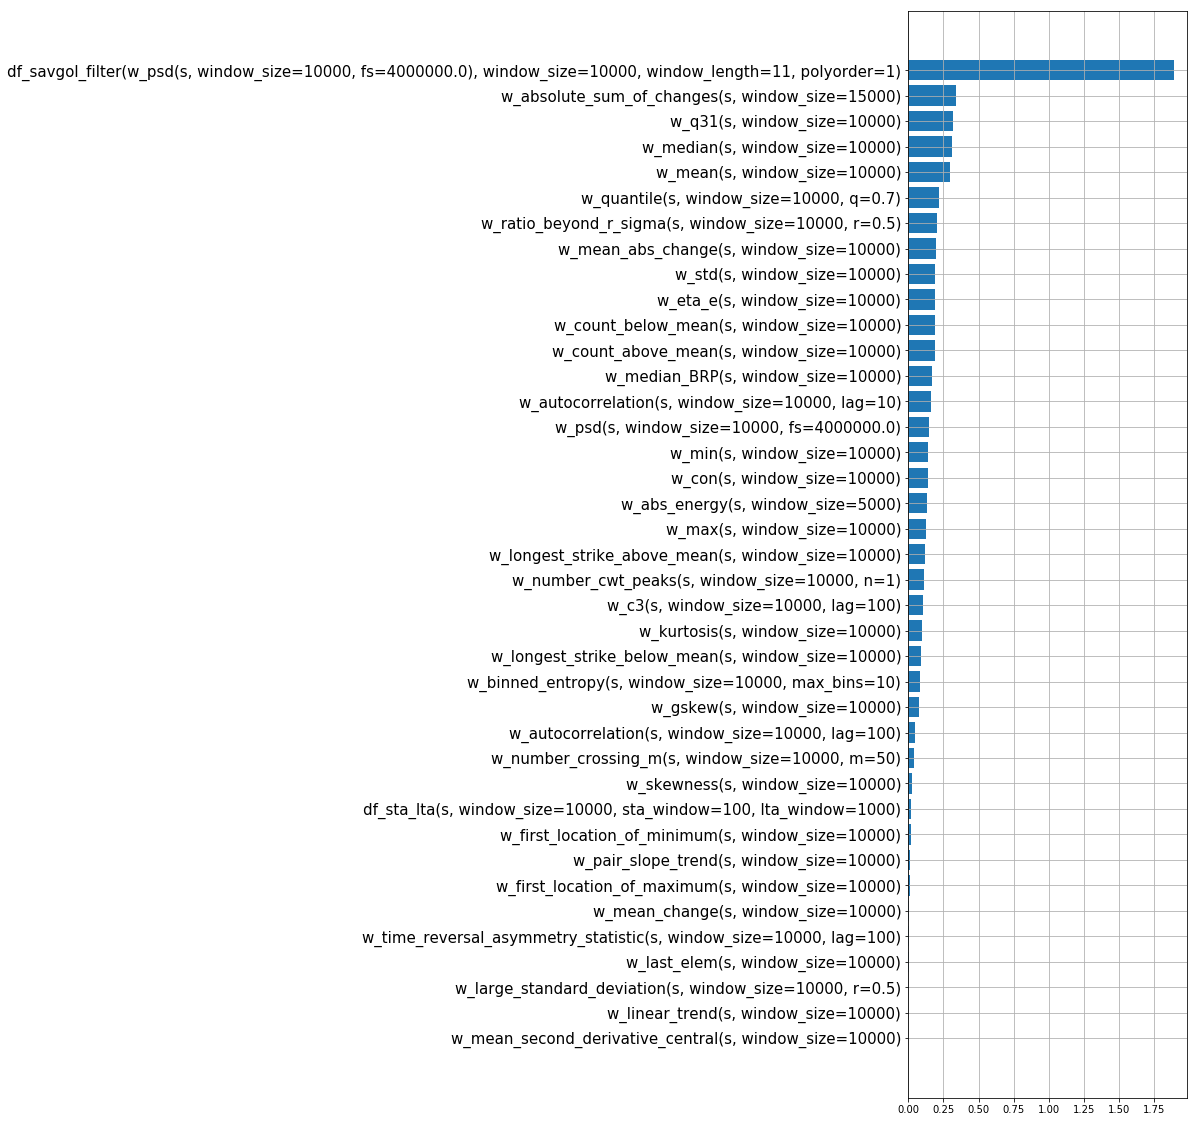

In [187]:
from matplotlib import pyplot as plt
def bar_chart(features, scores) -> None:
    fig = plt.figure(figsize = (5,20))
    ax = plt.barh(np.arange(len(scores_sorted)),scores_sorted, orientation = 'horizontal') #,
    plt.grid(True)
    plt.yticks(np.arange(len(features_sorted)), features_sorted, rotation = 0, size = 15) 
    plt.yticks(size = 15) 
    plt.show()
    
    
features_all = list(df_EQ2.columns)
scores_sorted, features_sorted = get_feature_importance(selector_univariate, features_all)
scores_sorted = scores_sorted[::-1]
features_sorted = features_sorted[::-1]
bar_chart(features_sorted, scores_sorted)

# Testing recursive feature elimination

In [190]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import AdaBoostRegressor as ABR
estimator = RFR()
selector_recursive = RFE(estimator, 10, step=2, verbose = 1)
selector_recursive = selector_recursive.fit(X_EQ2_u, y_EQ2)

X_EQ2_r, X_cols_EQ2_r = eliminate_features(selector_recursive, X_EQ2_u, X_cols_EQ2_u)

# print("Remaining features: ")
# print([col for indicator, col in zip(selector_recursive.support_,list(new_X_EQ2_cols)) if indicator == True])
# print(selector_recursive.ranking_)

Fitting estimator with 23 features.
Fitting estimator with 21 features.
Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.


In [183]:
X_EQ3_u, X_cols_EQ3_u = eliminate_features(selector_univariate, X_EQ3, X_cols_EQ3)
X_EQ3_r, X_cols_EQ3_r = eliminate_features(selector_recursive, X_EQ3_u, X_cols_EQ3_u)

/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [184]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn import svm
from sklearn.neural_network import MLPRegressor
estimator_all = MLPRegressor(hidden_layer_sizes=(100,75,50,25,10))
estimator_u = MLPRegressor(hidden_layer_sizes=(100,75,50,25,10))
estimator_r = MLPRegressor(hidden_layer_sizes=(100,75,50,25,10))

# estimator_all = MLPRegressor(hidden_layer_sizes=(100,25))
# estimator_u = MLPRegressor(hidden_layer_sizes=(100,25))
# estimator_r = MLPRegressor(hidden_layer_sizes=(100,25))

estimator_all.fit(X_EQ2, y_EQ2)
estimator_u.fit(X_EQ2_u, y_EQ2)
estimator_r.fit(X_EQ2_r, y_EQ2)

a = []
u = []
r = []
for i in range(101):
    a.append(mae(y_EQ2,estimator_all.predict(X_EQ2)))
    u.append(mae(y_EQ2,estimator_u.predict(X_EQ2_u)))
    r.append(mae(y_EQ2,estimator_r.predict(X_EQ2_r)))

print(np.median(a), np.median(u), np.median(r))

a = []
u = []
r = []
for i in range(101):
    a.append(mae(y_EQ3,estimator_all.predict(X_EQ3)))
    u.append(mae(y_EQ3,estimator_u.predict(X_EQ3_u)))
    r.append(mae(y_EQ3,estimator_r.predict(X_EQ3_r)))
    
print(np.median(a), np.median(u), np.median(r))

1.4330089777668846 1.8193293612583852 1.930669390972073
2.949112901402162 2.9631586136110744 3.1789542336533008


# Adding a linear trend to the predictions

3.8045590347972817

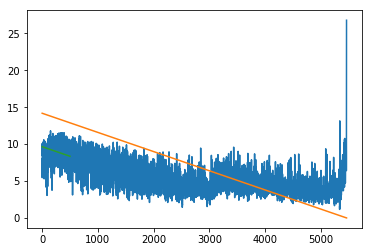

In [178]:
from scipy import stats
y_EQ3_predictions = estimator_r.predict(X_EQ3_r)
slope = (y_EQ3[-1] - y_EQ3[0])/len(y_EQ3)

def get_trend(predictions, slope):
    x = np.arange(len(predictions))
    B = -2*np.sum(predictions - slope*x)
    A = len(predictions)
    b = -B/(2*A)
    return np.maximum((slope*x + b),0), slope, b

trended_predictions_EQ3, slope, b = get_trend(y_EQ3_predictions[:500], slope)
plt.plot(y_EQ3_predictions)
plt.plot(y_EQ3)
plt.plot(trended_predictions_EQ3)
mae(y_EQ3, np.maximum(slope*np.arange(len(y_EQ3)) + b,0))

In [124]:
X_EQ2_cols = df_EQ2.columns[:-1][list(model.get_support())]
print(mae(y_EQ3,regressor.predict(X_EQ3)))

3.1820677610662407


# Module for parameter optimization

In [1]:
import sys
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter as sg
import pandas as pd
from scipy.optimize import minimize
sys.path.insert(0, '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/src/data_processing')
from dp_features import *
from sklearn.feature_selection import mutual_info_regression as MI
data_path = '/home/pavel/Documents/0Research/Projects/LANL-Earthquake/data/EQs/EQ_2.h5'
df_EQ2 = pd.read_hdf(data_path, key = 'table')
df_EQ2.columns = ['s','ttf']
s = df_EQ2.s
ttf = df_EQ2.ttf

def mutual_info(function, s, ttf, window_size):
    feature = function(s, window_size=int(window_size))
    ttf_reduced = w_last_elem(ttf, window_size=int(window_size))
    res = MI(feature, ttf_reduced)[0]
    return res

def plot_mi_winsize(function, s, ttf, window_sizes):
    res = []
    for i in range(len(window_sizes)):
        res.append(mutual_info(function,s,ttf,window_sizes[i]))
    
    figure = plt.figure(figsize = (10,5))
    plt.plot(window_sizes, res, 'r-', linewidth = 3, alpha = 0.7)
    plt.grid(True)
    plt.savefig(function.__name__)
    
window_sizes = np.linspace(1000,15000,14)
plot_mi_winsize(w_psd, s, ttf, window_sizes)

w_last_elem(df, window_size=1000): 100%|██████████| 44430/44430 [00:02<00:00, 18722.92it/s]


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_last_elem(df, window_size=2076): 100%|██████████| 21402/21402 [00:01<00:00, 18257.78it/s]


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_last_elem(df, window_size=3153): 100%|██████████| 14092/14092 [00:00<00:00, 19708.31it/s]


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_last_elem(df, window_size=4230): 100%|██████████| 10504/10504 [00:00<00:00, 19151.46it/s]


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_last_elem(df, window_size=5307): 100%|██████████| 8372/8372 [00:00<00:00, 19013.56it/s]


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=7461, (fs=4000000.0)):   0%|          | 0/5955 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=8538, (fs=4000000.0)):   0%|          | 0/5204 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=9615, (fs=4000000.0)):   0%|          | 0/4621 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=10692, (fs=4000000.0)):   0%|          | 0/4156 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=11769, (fs=4000000.0)):   0%|          | 0/3776 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=12846, (fs=4000000.0)):   0%|          | 7/3459 [00:00<00:50, 68.79it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=13923, (fs=4000000.0)):   4%|▍         | 132/3192 [00:00<00:02, 1311.43it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_psd(df, window_size=15000, (fs=4000000.0)):   6%|▌         | 168/2962 [00:00<00:01, 1676.60it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w_last_elem(df, window_size=15000): 100%|██████████| 2962/2962 [00:00<00:00, 18752.98it/s]


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1000.0
w_longest_strike_above_mean(df, window_size=1000): 100%|██████████| 44430/44430 [00:48<00:00, 917.59it/s] 
	 window decorator: 
	 - window size: 1000
w_last_elem(df, window_size=1000): 100%|██████████| 44430/44430 [00:02<00:00, 19525.19it/s]
	 window decorator: 
	 - window size: 1000


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


1498.3277591973244
w_longest_strike_above_mean(df, window_size=1498): 100%|██████████| 29660/29660 [00:44<00:00, 668.19it/s]
	 window decorator: 
	 - window size: 1498
w_last_elem(df, window_size=1498): 100%|██████████| 29660/29660 [00:01<00:00, 18870.75it/s]
	 window decorator: 
	 - window size: 1498


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


1996.6555183946489
w_longest_strike_above_mean(df, window_size=1996): 100%|██████████| 22260/22260 [00:49<00:00, 452.35it/s]
	 window decorator: 
	 - window size: 1996
w_last_elem(df, window_size=1996): 100%|██████████| 22260/22260 [00:01<00:00, 18534.50it/s]
	 window decorator: 
	 - window size: 1996


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


2494.983277591973
w_longest_strike_above_mean(df, window_size=2494): 100%|██████████| 17815/17815 [00:49<00:00, 361.33it/s]
	 window decorator: 
	 - window size: 2494
w_last_elem(df, window_size=2494): 100%|██████████| 17815/17815 [00:00<00:00, 18175.25it/s]
	 window decorator: 
	 - window size: 2494


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


2993.3110367892978
w_longest_strike_above_mean(df, window_size=2993): 100%|██████████| 14845/14845 [00:47<00:00, 312.79it/s]
	 window decorator: 
	 - window size: 2993
w_last_elem(df, window_size=2993): 100%|██████████| 14845/14845 [00:00<00:00, 20516.70it/s]
	 window decorator: 
	 - window size: 2993


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


3491.6387959866224
w_longest_strike_above_mean(df, window_size=3491): 100%|██████████| 12727/12727 [00:44<00:00, 284.55it/s]
	 window decorator: 
	 - window size: 3491
w_last_elem(df, window_size=3491): 100%|██████████| 12727/12727 [00:00<00:00, 17798.30it/s]
	 window decorator: 
	 - window size: 3491


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


3989.9665551839466
w_longest_strike_above_mean(df, window_size=3989): 100%|██████████| 11138/11138 [00:43<00:00, 257.78it/s]
	 window decorator: 
	 - window size: 3989
w_last_elem(df, window_size=3989): 100%|██████████| 11138/11138 [00:00<00:00, 20156.87it/s]
	 window decorator: 
	 - window size: 3989


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


4488.294314381271
w_longest_strike_above_mean(df, window_size=4488): 100%|██████████| 9900/9900 [00:45<00:00, 216.46it/s]
	 window decorator: 
	 - window size: 4488
w_last_elem(df, window_size=4488): 100%|██████████| 9900/9900 [00:00<00:00, 15920.73it/s]
	 window decorator: 
	 - window size: 4488


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


4986.6220735785955
w_longest_strike_above_mean(df, window_size=4986): 100%|██████████| 8911/8911 [00:49<00:00, 181.76it/s]
	 window decorator: 
	 - window size: 4986
w_last_elem(df, window_size=4986): 100%|██████████| 8911/8911 [00:00<00:00, 17888.47it/s]
	 window decorator: 
	 - window size: 4986


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


5484.94983277592
w_longest_strike_above_mean(df, window_size=5484): 100%|██████████| 8102/8102 [00:47<00:00, 171.77it/s]
	 window decorator: 
	 - window size: 5484
w_last_elem(df, window_size=5484): 100%|██████████| 8102/8102 [00:00<00:00, 17324.60it/s]
	 window decorator: 
	 - window size: 5484


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


5983.277591973245
w_longest_strike_above_mean(df, window_size=5983): 100%|██████████| 7426/7426 [00:45<00:00, 162.22it/s]
	 window decorator: 
	 - window size: 5983
w_last_elem(df, window_size=5983): 100%|██████████| 7426/7426 [00:00<00:00, 17787.47it/s]
	 window decorator: 
	 - window size: 5983


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


6481.605351170569
w_longest_strike_above_mean(df, window_size=6481): 100%|██████████| 6856/6856 [00:43<00:00, 157.53it/s]
	 window decorator: 
	 - window size: 6481
w_last_elem(df, window_size=6481): 100%|██████████| 6856/6856 [00:00<00:00, 20703.16it/s]
	 window decorator: 
	 - window size: 6481
6979.933110367893
w_longest_strike_above_mean(df, window_size=6979):   0%|          | 0/6367 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=6979): 100%|██████████| 6367/6367 [00:42<00:00, 150.32it/s]
	 window decorator: 
	 - window size: 6979
w_last_elem(df, window_size=6979): 100%|██████████| 6367/6367 [00:00<00:00, 18039.07it/s]
	 window decorator: 
	 - window size: 6979
7478.260869565218
w_longest_strike_above_mean(df, window_size=7478):   0%|          | 0/5942 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=7478): 100%|██████████| 5942/5942 [00:42<00:00, 138.96it/s]
	 window decorator: 
	 - window size: 7478
w_last_elem(df, window_size=7478): 100%|██████████| 5942/5942 [00:00<00:00, 19865.24it/s]
	 window decorator: 
	 - window size: 7478
7976.588628762542
w_longest_strike_above_mean(df, window_size=7976):   0%|          | 0/5571 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=7976): 100%|██████████| 5571/5571 [00:43<00:00, 128.61it/s]
	 window decorator: 
	 - window size: 7976
w_last_elem(df, window_size=7976): 100%|██████████| 5571/5571 [00:00<00:00, 20578.55it/s]
	 window decorator: 
	 - window size: 7976
8474.916387959867
w_longest_strike_above_mean(df, window_size=8474):   0%|          | 0/5244 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=8474): 100%|██████████| 5244/5244 [00:40<00:00, 128.44it/s]
	 window decorator: 
	 - window size: 8474
w_last_elem(df, window_size=8474): 100%|██████████| 5244/5244 [00:00<00:00, 20673.40it/s]
	 window decorator: 
	 - window size: 8474
8973.244147157191
w_longest_strike_above_mean(df, window_size=8973):   0%|          | 0/4952 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=8973): 100%|██████████| 4952/4952 [00:40<00:00, 121.10it/s]
	 window decorator: 
	 - window size: 8973
w_last_elem(df, window_size=8973): 100%|██████████| 4952/4952 [00:00<00:00, 20948.32it/s]
	 window decorator: 
	 - window size: 8973
9471.571906354515
w_longest_strike_above_mean(df, window_size=9471):   0%|          | 0/4692 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=9471): 100%|██████████| 4692/4692 [00:40<00:00, 115.02it/s]
	 window decorator: 
	 - window size: 9471
w_last_elem(df, window_size=9471): 100%|██████████| 4692/4692 [00:00<00:00, 20712.94it/s]
	 window decorator: 
	 - window size: 9471
9969.89966555184
w_longest_strike_above_mean(df, window_size=9969):   0%|          | 10/4457 [00:00<00:47, 93.00it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=9969): 100%|██████████| 4457/4457 [00:40<00:00, 109.88it/s]
	 window decorator: 
	 - window size: 9969
w_last_elem(df, window_size=9969): 100%|██████████| 4457/4457 [00:00<00:00, 20959.46it/s]
	 window decorator: 
	 - window size: 9969
10468.227424749164
w_longest_strike_above_mean(df, window_size=10468):   0%|          | 10/4245 [00:00<00:45, 92.56it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=10468): 100%|██████████| 4245/4245 [00:43<00:00, 96.60it/s] 
	 window decorator: 
	 - window size: 10468
w_last_elem(df, window_size=10468): 100%|██████████| 4245/4245 [00:00<00:00, 19404.02it/s]
	 window decorator: 
	 - window size: 10468
10966.55518394649
w_longest_strike_above_mean(df, window_size=10966):   0%|          | 7/4052 [00:00<00:57, 69.99it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=10966): 100%|██████████| 4052/4052 [00:42<00:00, 95.71it/s] 
	 window decorator: 
	 - window size: 10966
w_last_elem(df, window_size=10966): 100%|██████████| 4052/4052 [00:00<00:00, 20792.66it/s]
	 window decorator: 
	 - window size: 10966
11464.882943143813
w_longest_strike_above_mean(df, window_size=11464):   0%|          | 9/3876 [00:00<00:45, 84.51it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=11464): 100%|██████████| 3876/3876 [00:40<00:00, 94.74it/s] 
	 window decorator: 
	 - window size: 11464
w_last_elem(df, window_size=11464): 100%|██████████| 3876/3876 [00:00<00:00, 20923.23it/s]
	 window decorator: 
	 - window size: 11464
11963.210702341137
w_longest_strike_above_mean(df, window_size=11963):   0%|          | 9/3714 [00:00<00:45, 81.74it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=11963): 100%|██████████| 3714/3714 [00:40<00:00, 91.39it/s] 
	 window decorator: 
	 - window size: 11963
w_last_elem(df, window_size=11963): 100%|██████████| 3714/3714 [00:00<00:00, 18094.27it/s]
	 window decorator: 
	 - window size: 11963
12461.538461538463
w_longest_strike_above_mean(df, window_size=12461):   0%|          | 0/3566 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=12461): 100%|██████████| 3566/3566 [00:40<00:00, 87.27it/s] 
	 window decorator: 
	 - window size: 12461
w_last_elem(df, window_size=12461): 100%|██████████| 3566/3566 [00:00<00:00, 20892.86it/s]
	 window decorator: 
	 - window size: 12461
12959.866220735787
w_longest_strike_above_mean(df, window_size=12959):   0%|          | 8/3429 [00:00<00:44, 76.52it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=12959): 100%|██████████| 3429/3429 [00:41<00:00, 82.44it/s] 
	 window decorator: 
	 - window size: 12959
w_last_elem(df, window_size=12959): 100%|██████████| 3429/3429 [00:00<00:00, 19516.68it/s]
	 window decorator: 
	 - window size: 12959
13458.19397993311
w_longest_strike_above_mean(df, window_size=13458):   0%|          | 8/3302 [00:00<00:45, 71.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=13458): 100%|██████████| 3302/3302 [00:41<00:00, 78.91it/s]
	 window decorator: 
	 - window size: 13458
w_last_elem(df, window_size=13458): 100%|██████████| 3302/3302 [00:00<00:00, 20030.13it/s]
	 window decorator: 
	 - window size: 13458
13956.521739130436
w_longest_strike_above_mean(df, window_size=13956):   0%|          | 7/3184 [00:00<00:45, 69.46it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=13956): 100%|██████████| 3184/3184 [00:40<00:00, 79.43it/s]
	 window decorator: 
	 - window size: 13956
w_last_elem(df, window_size=13956): 100%|██████████| 3184/3184 [00:00<00:00, 20115.20it/s]
	 window decorator: 
	 - window size: 13956
14454.84949832776
w_longest_strike_above_mean(df, window_size=14454):   0%|          | 7/3074 [00:00<00:48, 63.25it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=14454): 100%|██████████| 3074/3074 [00:40<00:00, 75.29it/s]
	 window decorator: 
	 - window size: 14454
w_last_elem(df, window_size=14454): 100%|██████████| 3074/3074 [00:00<00:00, 19773.95it/s]
	 window decorator: 
	 - window size: 14454
14953.177257525083
w_longest_strike_above_mean(df, window_size=14953):   0%|          | 7/2972 [00:00<00:46, 64.12it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=14953): 100%|██████████| 2972/2972 [00:42<00:00, 69.38it/s]
	 window decorator: 
	 - window size: 14953
w_last_elem(df, window_size=14953): 100%|██████████| 2972/2972 [00:00<00:00, 19314.39it/s]
	 window decorator: 
	 - window size: 14953
15451.505016722409
w_longest_strike_above_mean(df, window_size=15451):   0%|          | 6/2876 [00:00<00:48, 59.35it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=15451): 100%|██████████| 2876/2876 [00:42<00:00, 67.00it/s]
	 window decorator: 
	 - window size: 15451
w_last_elem(df, window_size=15451): 100%|██████████| 2876/2876 [00:00<00:00, 15125.96it/s]
	 window decorator: 
	 - window size: 15451
15949.832775919733
w_longest_strike_above_mean(df, window_size=15949):   0%|          | 4/2786 [00:00<01:16, 36.53it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=15949): 100%|██████████| 2786/2786 [00:43<00:00, 61.79it/s]
	 window decorator: 
	 - window size: 15949
w_last_elem(df, window_size=15949): 100%|██████████| 2786/2786 [00:00<00:00, 20155.74it/s]
	 window decorator: 
	 - window size: 15949
16448.16053511706
w_longest_strike_above_mean(df, window_size=16448):   0%|          | 6/2702 [00:00<00:46, 57.65it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=16448): 100%|██████████| 2702/2702 [00:39<00:00, 67.69it/s]
	 window decorator: 
	 - window size: 16448
w_last_elem(df, window_size=16448): 100%|██████████| 2702/2702 [00:00<00:00, 20108.36it/s]
	 window decorator: 
	 - window size: 16448
16946.488294314382
w_longest_strike_above_mean(df, window_size=16946):   0%|          | 6/2622 [00:00<00:46, 56.09it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=16946): 100%|██████████| 2622/2622 [00:39<00:00, 66.01it/s]
	 window decorator: 
	 - window size: 16946
w_last_elem(df, window_size=16946): 100%|██████████| 2622/2622 [00:00<00:00, 20530.41it/s]
	 window decorator: 
	 - window size: 16946
17444.816053511706
w_longest_strike_above_mean(df, window_size=17444):   0%|          | 6/2547 [00:00<00:45, 56.01it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=17444): 100%|██████████| 2547/2547 [00:41<00:00, 61.94it/s]
	 window decorator: 
	 - window size: 17444
w_last_elem(df, window_size=17444): 100%|██████████| 2547/2547 [00:00<00:00, 19734.86it/s]
	 window decorator: 
	 - window size: 17444
17943.14381270903
w_longest_strike_above_mean(df, window_size=17943):   0%|          | 6/2477 [00:00<00:47, 52.44it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=17943): 100%|██████████| 2477/2477 [00:40<00:00, 61.49it/s]
	 window decorator: 
	 - window size: 17943
w_last_elem(df, window_size=17943): 100%|██████████| 2477/2477 [00:00<00:00, 19812.45it/s]
	 window decorator: 
	 - window size: 17943
18441.471571906357
w_longest_strike_above_mean(df, window_size=18441):   0%|          | 6/2410 [00:00<00:46, 51.88it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=18441): 100%|██████████| 2410/2410 [00:39<00:00, 60.26it/s]
	 window decorator: 
	 - window size: 18441
w_last_elem(df, window_size=18441): 100%|██████████| 2410/2410 [00:00<00:00, 19959.55it/s]
	 window decorator: 
	 - window size: 18441
18939.79933110368
w_longest_strike_above_mean(df, window_size=18939):   0%|          | 5/2346 [00:00<00:47, 49.15it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=18939): 100%|██████████| 2346/2346 [00:41<00:00, 56.44it/s]
	 window decorator: 
	 - window size: 18939
w_last_elem(df, window_size=18939): 100%|██████████| 2346/2346 [00:00<00:00, 19517.64it/s]
	 window decorator: 
	 - window size: 18939
19438.127090301005
w_longest_strike_above_mean(df, window_size=19438):   0%|          | 5/2286 [00:00<00:47, 48.19it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=19438): 100%|██████████| 2286/2286 [00:41<00:00, 51.62it/s]
	 window decorator: 
	 - window size: 19438
w_last_elem(df, window_size=19438): 100%|██████████| 2286/2286 [00:00<00:00, 20196.65it/s]
	 window decorator: 
	 - window size: 19438
19936.45484949833
w_longest_strike_above_mean(df, window_size=19936):   0%|          | 5/2229 [00:00<00:47, 47.00it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=19936): 100%|██████████| 2229/2229 [00:42<00:00, 53.04it/s]
	 window decorator: 
	 - window size: 19936
w_last_elem(df, window_size=19936): 100%|██████████| 2229/2229 [00:00<00:00, 19821.49it/s]
	 window decorator: 
	 - window size: 19936
20434.782608695652
w_longest_strike_above_mean(df, window_size=20434):   0%|          | 5/2175 [00:00<00:46, 46.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=20434): 100%|██████████| 2175/2175 [00:40<00:00, 54.29it/s]
	 window decorator: 
	 - window size: 20434
w_last_elem(df, window_size=20434): 100%|██████████| 2175/2175 [00:00<00:00, 19976.99it/s]
	 window decorator: 
	 - window size: 20434
20933.11036789298
w_longest_strike_above_mean(df, window_size=20933):   0%|          | 5/2123 [00:00<00:46, 45.77it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=20933): 100%|██████████| 2123/2123 [00:42<00:00, 50.38it/s]
	 window decorator: 
	 - window size: 20933
w_last_elem(df, window_size=20933): 100%|██████████| 2123/2123 [00:00<00:00, 19647.16it/s]
	 window decorator: 
	 - window size: 20933
21431.438127090303
w_longest_strike_above_mean(df, window_size=21431):   0%|          | 5/2074 [00:00<00:49, 41.75it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=21431): 100%|██████████| 2074/2074 [00:40<00:00, 51.70it/s]
	 window decorator: 
	 - window size: 21431
w_last_elem(df, window_size=21431): 100%|██████████| 2074/2074 [00:00<00:00, 20269.18it/s]
	 window decorator: 
	 - window size: 21431
21929.765886287627
w_longest_strike_above_mean(df, window_size=21929):   0%|          | 5/2027 [00:00<00:46, 43.66it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=21929): 100%|██████████| 2027/2027 [00:40<00:00, 49.79it/s]
	 window decorator: 
	 - window size: 21929
w_last_elem(df, window_size=21929): 100%|██████████| 2027/2027 [00:00<00:00, 19787.45it/s]
	 window decorator: 
	 - window size: 21929
22428.09364548495
w_longest_strike_above_mean(df, window_size=22428):   0%|          | 5/1981 [00:00<00:45, 43.09it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=22428): 100%|██████████| 1981/1981 [00:40<00:00, 48.74it/s]
	 window decorator: 
	 - window size: 22428
w_last_elem(df, window_size=22428): 100%|██████████| 1981/1981 [00:00<00:00, 17866.75it/s]
	 window decorator: 
	 - window size: 22428
22926.421404682274
w_longest_strike_above_mean(df, window_size=22926):   0%|          | 4/1938 [00:00<00:58, 33.33it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=22926): 100%|██████████| 1938/1938 [00:41<00:00, 42.40it/s]
	 window decorator: 
	 - window size: 22926
w_last_elem(df, window_size=22926): 100%|██████████| 1938/1938 [00:00<00:00, 20246.14it/s]
	 window decorator: 
	 - window size: 22926
23424.7491638796
w_longest_strike_above_mean(df, window_size=23424):   0%|          | 5/1897 [00:00<00:45, 41.60it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=23424): 100%|██████████| 1897/1897 [00:40<00:00, 46.52it/s]
	 window decorator: 
	 - window size: 23424
w_last_elem(df, window_size=23424): 100%|██████████| 1897/1897 [00:00<00:00, 18604.48it/s]
	 window decorator: 
	 - window size: 23424
23923.076923076926
w_longest_strike_above_mean(df, window_size=23923):   0%|          | 4/1858 [00:00<00:46, 39.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=23923): 100%|██████████| 1858/1858 [00:40<00:00, 46.07it/s]
	 window decorator: 
	 - window size: 23923
w_last_elem(df, window_size=23923): 100%|██████████| 1858/1858 [00:00<00:00, 19470.91it/s]
	 window decorator: 
	 - window size: 23923
24421.40468227425
w_longest_strike_above_mean(df, window_size=24421):   0%|          | 4/1820 [00:00<00:47, 38.60it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=24421): 100%|██████████| 1820/1820 [00:39<00:00, 45.55it/s]
	 window decorator: 
	 - window size: 24421
w_last_elem(df, window_size=24421): 100%|██████████| 1820/1820 [00:00<00:00, 19118.54it/s]
	 window decorator: 
	 - window size: 24421
24919.732441471573
w_longest_strike_above_mean(df, window_size=24919):   0%|          | 4/1783 [00:00<00:46, 37.92it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=24919): 100%|██████████| 1783/1783 [00:40<00:00, 40.63it/s]
	 window decorator: 
	 - window size: 24919
w_last_elem(df, window_size=24919): 100%|██████████| 1783/1783 [00:00<00:00, 19626.35it/s]
	 window decorator: 
	 - window size: 24919
25418.060200668897
w_longest_strike_above_mean(df, window_size=25418):   0%|          | 4/1748 [00:00<00:45, 38.37it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=25418): 100%|██████████| 1748/1748 [00:39<00:00, 40.09it/s]
	 window decorator: 
	 - window size: 25418
w_last_elem(df, window_size=25418): 100%|██████████| 1748/1748 [00:00<00:00, 19896.18it/s]
	 window decorator: 
	 - window size: 25418
25916.38795986622
w_longest_strike_above_mean(df, window_size=25916):   0%|          | 4/1715 [00:00<00:45, 37.39it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=25916): 100%|██████████| 1715/1715 [00:39<00:00, 42.88it/s]
	 window decorator: 
	 - window size: 25916
w_last_elem(df, window_size=25916): 100%|██████████| 1715/1715 [00:00<00:00, 20203.83it/s]
	 window decorator: 
	 - window size: 25916
26414.715719063548
w_longest_strike_above_mean(df, window_size=26414):   0%|          | 4/1683 [00:00<00:46, 36.37it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=26414): 100%|██████████| 1683/1683 [00:40<00:00, 41.97it/s]
	 window decorator: 
	 - window size: 26414
w_last_elem(df, window_size=26414): 100%|██████████| 1683/1683 [00:00<00:00, 19920.23it/s]
	 window decorator: 
	 - window size: 26414
26913.04347826087
w_longest_strike_above_mean(df, window_size=26913):   0%|          | 4/1651 [00:00<00:45, 35.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=26913): 100%|██████████| 1651/1651 [00:40<00:00, 40.71it/s]
	 window decorator: 
	 - window size: 26913
w_last_elem(df, window_size=26913): 100%|██████████| 1651/1651 [00:00<00:00, 20184.67it/s]
	 window decorator: 
	 - window size: 26913
27411.371237458196
w_longest_strike_above_mean(df, window_size=27411):   0%|          | 3/1621 [00:00<00:56, 28.80it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=27411): 100%|██████████| 1621/1621 [00:40<00:00, 40.34it/s]
	 window decorator: 
	 - window size: 27411
w_last_elem(df, window_size=27411): 100%|██████████| 1621/1621 [00:00<00:00, 20032.84it/s]
	 window decorator: 
	 - window size: 27411
27909.69899665552
w_longest_strike_above_mean(df, window_size=27909):   0%|          | 4/1592 [00:00<00:45, 34.76it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=27909): 100%|██████████| 1592/1592 [00:39<00:00, 36.28it/s]
	 window decorator: 
	 - window size: 27909
w_last_elem(df, window_size=27909): 100%|██████████| 1592/1592 [00:00<00:00, 19357.62it/s]
	 window decorator: 
	 - window size: 27909
28408.026755852843
w_longest_strike_above_mean(df, window_size=28408):   0%|          | 4/1564 [00:00<00:45, 34.42it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=28408): 100%|██████████| 1564/1564 [00:40<00:00, 38.97it/s]
	 window decorator: 
	 - window size: 28408
w_last_elem(df, window_size=28408): 100%|██████████| 1564/1564 [00:00<00:00, 18842.47it/s]
	 window decorator: 
	 - window size: 28408
28906.354515050167
w_longest_strike_above_mean(df, window_size=28906):   0%|          | 4/1538 [00:00<00:45, 33.39it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=28906): 100%|██████████| 1538/1538 [00:40<00:00, 38.28it/s]
	 window decorator: 
	 - window size: 28906
w_last_elem(df, window_size=28906): 100%|██████████| 1538/1538 [00:00<00:00, 19385.98it/s]
	 window decorator: 
	 - window size: 28906
29404.682274247494
w_longest_strike_above_mean(df, window_size=29404):   0%|          | 4/1511 [00:00<00:45, 33.33it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=29404): 100%|██████████| 1511/1511 [00:40<00:00, 37.68it/s]
	 window decorator: 
	 - window size: 29404
w_last_elem(df, window_size=29404): 100%|██████████| 1511/1511 [00:00<00:00, 19877.41it/s]
	 window decorator: 
	 - window size: 29404
29903.010033444818
w_longest_strike_above_mean(df, window_size=29903):   0%|          | 4/1486 [00:00<00:45, 32.37it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=29903): 100%|██████████| 1486/1486 [00:40<00:00, 36.79it/s]
	 window decorator: 
	 - window size: 29903
w_last_elem(df, window_size=29903): 100%|██████████| 1486/1486 [00:00<00:00, 19085.28it/s]
	 window decorator: 
	 - window size: 29903
30401.33779264214
w_longest_strike_above_mean(df, window_size=30401):   0%|          | 4/1462 [00:00<00:46, 31.48it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=30401): 100%|██████████| 1462/1462 [00:39<00:00, 36.69it/s]
	 window decorator: 
	 - window size: 30401
w_last_elem(df, window_size=30401): 100%|██████████| 1462/1462 [00:00<00:00, 20655.40it/s]
	 window decorator: 
	 - window size: 30401
30899.665551839465
w_longest_strike_above_mean(df, window_size=30899):   0%|          | 4/1438 [00:00<00:46, 31.10it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=30899): 100%|██████████| 1438/1438 [00:39<00:00, 36.07it/s]
	 window decorator: 
	 - window size: 30899
w_last_elem(df, window_size=30899): 100%|██████████| 1438/1438 [00:00<00:00, 20478.71it/s]
	 window decorator: 
	 - window size: 30899
31397.99331103679
w_longest_strike_above_mean(df, window_size=31397):   0%|          | 4/1416 [00:00<00:46, 30.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=31397): 100%|██████████| 1416/1416 [00:39<00:00, 34.75it/s]
	 window decorator: 
	 - window size: 31397
w_last_elem(df, window_size=31397): 100%|██████████| 1416/1416 [00:00<00:00, 19411.35it/s]
	 window decorator: 
	 - window size: 31397
31896.321070234117
w_longest_strike_above_mean(df, window_size=31896):   0%|          | 3/1393 [00:00<00:49, 28.31it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=31896): 100%|██████████| 1393/1393 [00:40<00:00, 34.73it/s]
	 window decorator: 
	 - window size: 31896
w_last_elem(df, window_size=31896): 100%|██████████| 1393/1393 [00:00<00:00, 18572.73it/s]
	 window decorator: 
	 - window size: 31896
32394.64882943144
w_longest_strike_above_mean(df, window_size=32394):   0%|          | 3/1372 [00:00<00:46, 29.60it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=32394): 100%|██████████| 1372/1372 [00:40<00:00, 34.03it/s]
	 window decorator: 
	 - window size: 32394
w_last_elem(df, window_size=32394): 100%|██████████| 1372/1372 [00:00<00:00, 19378.12it/s]
	 window decorator: 
	 - window size: 32394
32892.976588628764
w_longest_strike_above_mean(df, window_size=32892):   0%|          | 3/1351 [00:00<00:46, 29.13it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=32892): 100%|██████████| 1351/1351 [00:39<00:00, 34.13it/s]
	 window decorator: 
	 - window size: 32892
w_last_elem(df, window_size=32892): 100%|██████████| 1351/1351 [00:00<00:00, 18841.94it/s]
	 window decorator: 
	 - window size: 32892
33391.30434782609
w_longest_strike_above_mean(df, window_size=33391):   0%|          | 3/1331 [00:00<00:46, 28.77it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=33391): 100%|██████████| 1331/1331 [00:39<00:00, 33.84it/s]
	 window decorator: 
	 - window size: 33391
w_last_elem(df, window_size=33391): 100%|██████████| 1331/1331 [00:00<00:00, 19846.35it/s]
	 window decorator: 
	 - window size: 33391
33889.63210702341
w_longest_strike_above_mean(df, window_size=33889):   0%|          | 3/1312 [00:00<00:46, 28.23it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=33889): 100%|██████████| 1312/1312 [00:40<00:00, 32.70it/s]
	 window decorator: 
	 - window size: 33889
w_last_elem(df, window_size=33889): 100%|██████████| 1312/1312 [00:00<00:00, 19756.82it/s]
	 window decorator: 
	 - window size: 33889
34387.959866220735
w_longest_strike_above_mean(df, window_size=34387):   0%|          | 3/1293 [00:00<00:48, 26.59it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=34387): 100%|██████████| 1293/1293 [00:40<00:00, 31.89it/s]
	 window decorator: 
	 - window size: 34387
w_last_elem(df, window_size=34387): 100%|██████████| 1293/1293 [00:00<00:00, 20610.09it/s]
	 window decorator: 
	 - window size: 34387
34886.28762541806
w_longest_strike_above_mean(df, window_size=34886):   0%|          | 3/1274 [00:00<00:59, 21.28it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=34886): 100%|██████████| 1274/1274 [00:40<00:00, 31.68it/s]
	 window decorator: 
	 - window size: 34886
w_last_elem(df, window_size=34886): 100%|██████████| 1274/1274 [00:00<00:00, 19963.03it/s]
	 window decorator: 
	 - window size: 34886
35384.61538461538
w_longest_strike_above_mean(df, window_size=35384):   0%|          | 3/1256 [00:00<00:47, 26.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=35384): 100%|██████████| 1256/1256 [00:40<00:00, 31.36it/s]
	 window decorator: 
	 - window size: 35384
w_last_elem(df, window_size=35384): 100%|██████████| 1256/1256 [00:00<00:00, 21020.64it/s]
	 window decorator: 
	 - window size: 35384
35882.943143812714
w_longest_strike_above_mean(df, window_size=35882):   0%|          | 3/1239 [00:00<00:48, 25.54it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=35882): 100%|██████████| 1239/1239 [00:39<00:00, 31.18it/s]
	 window decorator: 
	 - window size: 35882
w_last_elem(df, window_size=35882): 100%|██████████| 1239/1239 [00:00<00:00, 20734.06it/s]
	 window decorator: 
	 - window size: 35882
36381.27090301004
w_longest_strike_above_mean(df, window_size=36381):   0%|          | 3/1222 [00:00<00:46, 26.32it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=36381): 100%|██████████| 1222/1222 [00:39<00:00, 30.61it/s]
	 window decorator: 
	 - window size: 36381
w_last_elem(df, window_size=36381): 100%|██████████| 1222/1222 [00:00<00:00, 20124.39it/s]
	 window decorator: 
	 - window size: 36381
36879.59866220736
w_longest_strike_above_mean(df, window_size=36879):   0%|          | 3/1205 [00:00<00:45, 26.18it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=36879): 100%|██████████| 1205/1205 [00:40<00:00, 30.01it/s]
	 window decorator: 
	 - window size: 36879
w_last_elem(df, window_size=36879): 100%|██████████| 1205/1205 [00:00<00:00, 19758.16it/s]
	 window decorator: 
	 - window size: 36879
37377.926421404685
w_longest_strike_above_mean(df, window_size=37377):   0%|          | 3/1189 [00:00<00:45, 26.03it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=37377): 100%|██████████| 1189/1189 [00:40<00:00, 27.59it/s]
	 window decorator: 
	 - window size: 37377
w_last_elem(df, window_size=37377): 100%|██████████| 1189/1189 [00:00<00:00, 20154.17it/s]
	 window decorator: 
	 - window size: 37377
37876.25418060201
w_longest_strike_above_mean(df, window_size=37876):   0%|          | 3/1174 [00:00<00:46, 25.12it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=37876): 100%|██████████| 1174/1174 [00:40<00:00, 29.30it/s]
	 window decorator: 
	 - window size: 37876
w_last_elem(df, window_size=37876): 100%|██████████| 1174/1174 [00:00<00:00, 19100.22it/s]
	 window decorator: 
	 - window size: 37876
38374.58193979933
w_longest_strike_above_mean(df, window_size=38374):   0%|          | 3/1158 [00:00<00:46, 24.70it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=38374): 100%|██████████| 1158/1158 [00:40<00:00, 28.87it/s]
	 window decorator: 
	 - window size: 38374
w_last_elem(df, window_size=38374): 100%|██████████| 1158/1158 [00:00<00:00, 20408.69it/s]
	 window decorator: 
	 - window size: 38374
38872.90969899666
w_longest_strike_above_mean(df, window_size=38872):   0%|          | 3/1143 [00:00<00:46, 24.67it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=38872): 100%|██████████| 1143/1143 [00:40<00:00, 28.46it/s]
	 window decorator: 
	 - window size: 38872
w_last_elem(df, window_size=38872): 100%|██████████| 1143/1143 [00:00<00:00, 18935.87it/s]
	 window decorator: 
	 - window size: 38872
39371.23745819398
w_longest_strike_above_mean(df, window_size=39371):   0%|          | 3/1129 [00:00<00:46, 24.12it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=39371): 100%|██████████| 1129/1129 [00:40<00:00, 27.98it/s]
	 window decorator: 
	 - window size: 39371
w_last_elem(df, window_size=39371): 100%|██████████| 1129/1129 [00:00<00:00, 20071.50it/s]
	 window decorator: 
	 - window size: 39371
39869.565217391304
w_longest_strike_above_mean(df, window_size=39869):   0%|          | 3/1115 [00:00<00:46, 23.86it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=39869): 100%|██████████| 1115/1115 [00:40<00:00, 27.55it/s]
	 window decorator: 
	 - window size: 39869
w_last_elem(df, window_size=39869): 100%|██████████| 1115/1115 [00:00<00:00, 20565.47it/s]
	 window decorator: 
	 - window size: 39869
40367.89297658863
w_longest_strike_above_mean(df, window_size=40367):   0%|          | 3/1101 [00:00<00:46, 23.73it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=40367): 100%|██████████| 1101/1101 [00:39<00:00, 26.26it/s]
	 window decorator: 
	 - window size: 40367
w_last_elem(df, window_size=40367): 100%|██████████| 1101/1101 [00:00<00:00, 19857.62it/s]
	 window decorator: 
	 - window size: 40367
40866.22073578596
w_longest_strike_above_mean(df, window_size=40866):   0%|          | 3/1088 [00:00<00:46, 23.39it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=40866): 100%|██████████| 1088/1088 [00:39<00:00, 27.34it/s]
	 window decorator: 
	 - window size: 40866
w_last_elem(df, window_size=40866): 100%|██████████| 1088/1088 [00:00<00:00, 20193.83it/s]
	 window decorator: 
	 - window size: 40866
41364.54849498328
w_longest_strike_above_mean(df, window_size=41364):   0%|          | 3/1075 [00:00<00:45, 23.31it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=41364): 100%|██████████| 1075/1075 [00:39<00:00, 27.05it/s]
	 window decorator: 
	 - window size: 41364
w_last_elem(df, window_size=41364): 100%|██████████| 1075/1075 [00:00<00:00, 19856.77it/s]
	 window decorator: 
	 - window size: 41364
41862.876254180606
w_longest_strike_above_mean(df, window_size=41862):   0%|          | 3/1062 [00:00<00:46, 22.87it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=41862): 100%|██████████| 1062/1062 [00:40<00:00, 26.19it/s]
	 window decorator: 
	 - window size: 41862
w_last_elem(df, window_size=41862): 100%|██████████| 1062/1062 [00:00<00:00, 20596.73it/s]
	 window decorator: 
	 - window size: 41862
42361.20401337793
w_longest_strike_above_mean(df, window_size=42361):   0%|          | 3/1049 [00:00<00:46, 22.39it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=42361): 100%|██████████| 1049/1049 [00:40<00:00, 23.95it/s]
	 window decorator: 
	 - window size: 42361
w_last_elem(df, window_size=42361): 100%|██████████| 1049/1049 [00:00<00:00, 19764.10it/s]
	 window decorator: 
	 - window size: 42361
42859.531772575254
w_longest_strike_above_mean(df, window_size=42859):   0%|          | 3/1037 [00:00<00:46, 22.41it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=42859): 100%|██████████| 1037/1037 [00:39<00:00, 26.20it/s]
	 window decorator: 
	 - window size: 42859
w_last_elem(df, window_size=42859): 100%|██████████| 1037/1037 [00:00<00:00, 20995.11it/s]
	 window decorator: 
	 - window size: 42859
43357.85953177258
w_longest_strike_above_mean(df, window_size=43357):   0%|          | 3/1025 [00:00<00:45, 22.46it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=43357): 100%|██████████| 1025/1025 [00:39<00:00, 24.04it/s]
	 window decorator: 
	 - window size: 43357
w_last_elem(df, window_size=43357): 100%|██████████| 1025/1025 [00:00<00:00, 19933.80it/s]
	 window decorator: 
	 - window size: 43357
43856.1872909699
w_longest_strike_above_mean(df, window_size=43856):   0%|          | 3/1014 [00:00<00:45, 22.36it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=43856): 100%|██████████| 1014/1014 [00:39<00:00, 25.61it/s]
	 window decorator: 
	 - window size: 43856
w_last_elem(df, window_size=43856): 100%|██████████| 1014/1014 [00:00<00:00, 19400.27it/s]
	 window decorator: 
	 - window size: 43856
44354.515050167225
w_longest_strike_above_mean(df, window_size=44354):   0%|          | 3/1002 [00:00<00:48, 20.80it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=44354): 100%|██████████| 1002/1002 [00:40<00:00, 23.20it/s]
	 window decorator: 
	 - window size: 44354
w_last_elem(df, window_size=44354): 100%|██████████| 1002/1002 [00:00<00:00, 20069.59it/s]
	 window decorator: 
	 - window size: 44354
44852.84280936455
w_longest_strike_above_mean(df, window_size=44852):   0%|          | 3/991 [00:00<00:46, 21.40it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=44852): 100%|██████████| 991/991 [00:40<00:00, 24.67it/s]
	 window decorator: 
	 - window size: 44852
w_last_elem(df, window_size=44852): 100%|██████████| 991/991 [00:00<00:00, 20615.38it/s]
	 window decorator: 
	 - window size: 44852
45351.17056856187
w_longest_strike_above_mean(df, window_size=45351):   0%|          | 3/980 [00:00<00:46, 20.79it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=45351): 100%|██████████| 980/980 [00:40<00:00, 24.34it/s]
	 window decorator: 
	 - window size: 45351
w_last_elem(df, window_size=45351): 100%|██████████| 980/980 [00:00<00:00, 20142.79it/s]
	 window decorator: 
	 - window size: 45351
45849.4983277592
w_longest_strike_above_mean(df, window_size=45849):   0%|          | 3/970 [00:00<00:46, 20.78it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=45849): 100%|██████████| 970/970 [00:39<00:00, 24.26it/s]
	 window decorator: 
	 - window size: 45849
w_last_elem(df, window_size=45849): 100%|██████████| 970/970 [00:00<00:00, 20555.74it/s]
	 window decorator: 
	 - window size: 45849
46347.82608695653
w_longest_strike_above_mean(df, window_size=46347):   0%|          | 3/959 [00:00<00:46, 20.71it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=46347): 100%|██████████| 959/959 [00:39<00:00, 24.30it/s]
	 window decorator: 
	 - window size: 46347
w_last_elem(df, window_size=46347): 100%|██████████| 959/959 [00:00<00:00, 20492.75it/s]
	 window decorator: 
	 - window size: 46347
46846.15384615385
w_longest_strike_above_mean(df, window_size=46846):   0%|          | 2/949 [00:00<00:48, 19.41it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=46846): 100%|██████████| 949/949 [00:40<00:00, 19.71it/s]
	 window decorator: 
	 - window size: 46846
w_last_elem(df, window_size=46846): 100%|██████████| 949/949 [00:00<00:00, 15997.79it/s]
	 window decorator: 
	 - window size: 46846
47344.481605351175
w_longest_strike_above_mean(df, window_size=47344):   0%|          | 2/939 [00:00<00:48, 19.17it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=47344): 100%|██████████| 939/939 [00:39<00:00, 23.83it/s]
	 window decorator: 
	 - window size: 47344
w_last_elem(df, window_size=47344): 100%|██████████| 939/939 [00:00<00:00, 20191.28it/s]
	 window decorator: 
	 - window size: 47344
47842.8093645485
w_longest_strike_above_mean(df, window_size=47842):   0%|          | 2/929 [00:00<00:46, 19.75it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=47842): 100%|██████████| 929/929 [00:40<00:00, 23.06it/s]
	 window decorator: 
	 - window size: 47842
w_last_elem(df, window_size=47842): 100%|██████████| 929/929 [00:00<00:00, 20309.12it/s]
	 window decorator: 
	 - window size: 47842
48341.13712374582
w_longest_strike_above_mean(df, window_size=48341):   0%|          | 2/920 [00:00<00:47, 19.29it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=48341): 100%|██████████| 920/920 [00:39<00:00, 23.13it/s]
	 window decorator: 
	 - window size: 48341
w_last_elem(df, window_size=48341): 100%|██████████| 920/920 [00:00<00:00, 20041.44it/s]
	 window decorator: 
	 - window size: 48341
48839.464882943146
w_longest_strike_above_mean(df, window_size=48839):   0%|          | 2/910 [00:00<00:46, 19.55it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=48839): 100%|██████████| 910/910 [00:39<00:00, 21.52it/s]
	 window decorator: 
	 - window size: 48839
w_last_elem(df, window_size=48839): 100%|██████████| 910/910 [00:00<00:00, 20908.56it/s]
	 window decorator: 
	 - window size: 48839
49337.79264214047
w_longest_strike_above_mean(df, window_size=49337):   0%|          | 2/901 [00:00<00:47, 18.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=49337): 100%|██████████| 901/901 [00:40<00:00, 21.72it/s]
	 window decorator: 
	 - window size: 49337
w_last_elem(df, window_size=49337): 100%|██████████| 901/901 [00:00<00:00, 20887.83it/s]
	 window decorator: 
	 - window size: 49337
49836.120401337794
w_longest_strike_above_mean(df, window_size=49836):   0%|          | 2/892 [00:00<00:46, 19.09it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=49836): 100%|██████████| 892/892 [00:40<00:00, 22.17it/s]
	 window decorator: 
	 - window size: 49836
w_last_elem(df, window_size=49836): 100%|██████████| 892/892 [00:00<00:00, 19546.00it/s]
	 window decorator: 
	 - window size: 49836
50334.44816053512
w_longest_strike_above_mean(df, window_size=50334):   0%|          | 2/883 [00:00<00:47, 18.51it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=50334): 100%|██████████| 883/883 [00:40<00:00, 22.04it/s]
	 window decorator: 
	 - window size: 50334
w_last_elem(df, window_size=50334): 100%|██████████| 883/883 [00:00<00:00, 19157.42it/s]
	 window decorator: 
	 - window size: 50334
50832.77591973244
w_longest_strike_above_mean(df, window_size=50832):   0%|          | 2/875 [00:00<00:46, 18.72it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=50832): 100%|██████████| 875/875 [00:39<00:00, 21.97it/s]
	 window decorator: 
	 - window size: 50832
w_last_elem(df, window_size=50832): 100%|██████████| 875/875 [00:00<00:00, 18974.83it/s]
	 window decorator: 
	 - window size: 50832
51331.103678929765
w_longest_strike_above_mean(df, window_size=51331):   0%|          | 2/866 [00:00<00:46, 18.66it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=51331): 100%|██████████| 866/866 [00:39<00:00, 21.13it/s]
	 window decorator: 
	 - window size: 51331
w_last_elem(df, window_size=51331): 100%|██████████| 866/866 [00:00<00:00, 19891.83it/s]
	 window decorator: 
	 - window size: 51331
51829.431438127096
w_longest_strike_above_mean(df, window_size=51829):   0%|          | 2/858 [00:00<00:46, 18.38it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=51829): 100%|██████████| 858/858 [00:40<00:00, 20.98it/s]
	 window decorator: 
	 - window size: 51829
w_last_elem(df, window_size=51829): 100%|██████████| 858/858 [00:00<00:00, 20612.60it/s]
	 window decorator: 
	 - window size: 51829
52327.75919732442
w_longest_strike_above_mean(df, window_size=52327):   0%|          | 2/850 [00:00<00:47, 17.71it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=52327): 100%|██████████| 850/850 [00:40<00:00, 21.18it/s]
	 window decorator: 
	 - window size: 52327
w_last_elem(df, window_size=52327): 100%|██████████| 850/850 [00:00<00:00, 19998.42it/s]
	 window decorator: 
	 - window size: 52327
52826.08695652174
w_longest_strike_above_mean(df, window_size=52826):   0%|          | 2/842 [00:00<00:46, 17.98it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=52826): 100%|██████████| 842/842 [00:39<00:00, 21.70it/s]
	 window decorator: 
	 - window size: 52826
w_last_elem(df, window_size=52826): 100%|██████████| 842/842 [00:00<00:00, 20412.24it/s]
	 window decorator: 
	 - window size: 52826
53324.41471571907
w_longest_strike_above_mean(df, window_size=53324):   0%|          | 2/834 [00:00<00:47, 17.65it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=53324): 100%|██████████| 834/834 [00:40<00:00, 20.76it/s]
	 window decorator: 
	 - window size: 53324
w_last_elem(df, window_size=53324): 100%|██████████| 834/834 [00:00<00:00, 20542.20it/s]
	 window decorator: 
	 - window size: 53324
53822.74247491639
w_longest_strike_above_mean(df, window_size=53822):   0%|          | 2/826 [00:00<00:47, 17.38it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=53822): 100%|██████████| 826/826 [00:39<00:00, 20.66it/s]
	 window decorator: 
	 - window size: 53822
w_last_elem(df, window_size=53822): 100%|██████████| 826/826 [00:00<00:00, 20762.76it/s]
	 window decorator: 
	 - window size: 53822
54321.070234113715
w_longest_strike_above_mean(df, window_size=54321):   0%|          | 2/818 [00:00<00:46, 17.55it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=54321): 100%|██████████| 818/818 [00:40<00:00, 18.22it/s]
	 window decorator: 
	 - window size: 54321
w_last_elem(df, window_size=54321): 100%|██████████| 818/818 [00:00<00:00, 18137.77it/s]
	 window decorator: 
	 - window size: 54321
54819.39799331104
w_longest_strike_above_mean(df, window_size=54819):   0%|          | 2/811 [00:00<00:48, 16.69it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=54819): 100%|██████████| 811/811 [00:39<00:00, 20.32it/s]
	 window decorator: 
	 - window size: 54819
w_last_elem(df, window_size=54819): 100%|██████████| 811/811 [00:00<00:00, 19600.57it/s]
	 window decorator: 
	 - window size: 54819
55317.72575250836
w_longest_strike_above_mean(df, window_size=55317):   0%|          | 2/804 [00:00<00:48, 16.69it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=55317): 100%|██████████| 804/804 [00:39<00:00, 20.17it/s]
	 window decorator: 
	 - window size: 55317
w_last_elem(df, window_size=55317): 100%|██████████| 804/804 [00:00<00:00, 20576.62it/s]
	 window decorator: 
	 - window size: 55317
55816.053511705686
w_longest_strike_above_mean(df, window_size=55816):   0%|          | 2/796 [00:00<00:47, 16.54it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=55816): 100%|██████████| 796/796 [00:39<00:00, 19.99it/s]
	 window decorator: 
	 - window size: 55816
w_last_elem(df, window_size=55816): 100%|██████████| 796/796 [00:00<00:00, 19686.46it/s]
	 window decorator: 
	 - window size: 55816
56314.38127090301
w_longest_strike_above_mean(df, window_size=56314):   0%|          | 2/789 [00:00<00:48, 16.33it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=56314): 100%|██████████| 789/789 [00:39<00:00, 19.85it/s]
	 window decorator: 
	 - window size: 56314
w_last_elem(df, window_size=56314): 100%|██████████| 789/789 [00:00<00:00, 20175.86it/s]
	 window decorator: 
	 - window size: 56314
56812.70903010033
w_longest_strike_above_mean(df, window_size=56812):   0%|          | 2/783 [00:00<00:46, 16.81it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=56812): 100%|██████████| 783/783 [00:40<00:00, 19.30it/s]
	 window decorator: 
	 - window size: 56812
w_last_elem(df, window_size=56812): 100%|██████████| 783/783 [00:00<00:00, 19125.97it/s]
	 window decorator: 
	 - window size: 56812
57311.036789297665
w_longest_strike_above_mean(df, window_size=57311):   0%|          | 2/776 [00:00<00:45, 17.01it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=57311): 100%|██████████| 776/776 [00:39<00:00, 19.42it/s]
	 window decorator: 
	 - window size: 57311
w_last_elem(df, window_size=57311): 100%|██████████| 776/776 [00:00<00:00, 20170.17it/s]
	 window decorator: 
	 - window size: 57311
57809.36454849499
w_longest_strike_above_mean(df, window_size=57809):   0%|          | 2/769 [00:00<00:48, 15.94it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=57809): 100%|██████████| 769/769 [00:40<00:00, 19.22it/s]
	 window decorator: 
	 - window size: 57809
w_last_elem(df, window_size=57809): 100%|██████████| 769/769 [00:00<00:00, 20349.65it/s]
	 window decorator: 
	 - window size: 57809
58307.69230769231
w_longest_strike_above_mean(df, window_size=58307):   0%|          | 2/762 [00:00<00:47, 15.89it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=58307): 100%|██████████| 762/762 [00:40<00:00, 17.15it/s]
	 window decorator: 
	 - window size: 58307
w_last_elem(df, window_size=58307): 100%|██████████| 762/762 [00:00<00:00, 19615.91it/s]
	 window decorator: 
	 - window size: 58307
58806.020066889636
w_longest_strike_above_mean(df, window_size=58806):   0%|          | 2/756 [00:00<00:46, 16.30it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=58806): 100%|██████████| 756/756 [00:39<00:00, 18.90it/s]
	 window decorator: 
	 - window size: 58806
w_last_elem(df, window_size=58806): 100%|██████████| 756/756 [00:00<00:00, 19797.55it/s]
	 window decorator: 
	 - window size: 58806
59304.34782608696
w_longest_strike_above_mean(df, window_size=59304):   0%|          | 2/750 [00:00<00:46, 15.95it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=59304): 100%|██████████| 750/750 [00:39<00:00, 18.79it/s]
	 window decorator: 
	 - window size: 59304
w_last_elem(df, window_size=59304): 100%|██████████| 750/750 [00:00<00:00, 20607.45it/s]
	 window decorator: 
	 - window size: 59304
59802.67558528428
w_longest_strike_above_mean(df, window_size=59802):   0%|          | 2/743 [00:00<00:47, 15.71it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=59802): 100%|██████████| 743/743 [00:40<00:00, 18.50it/s]
	 window decorator: 
	 - window size: 59802
w_last_elem(df, window_size=59802): 100%|██████████| 743/743 [00:00<00:00, 19487.65it/s]
	 window decorator: 
	 - window size: 59802
60301.00334448161
w_longest_strike_above_mean(df, window_size=60301):   0%|          | 2/737 [00:00<00:45, 16.18it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=60301): 100%|██████████| 737/737 [00:39<00:00, 18.50it/s]
	 window decorator: 
	 - window size: 60301
w_last_elem(df, window_size=60301): 100%|██████████| 737/737 [00:00<00:00, 20268.72it/s]
	 window decorator: 
	 - window size: 60301
60799.33110367893
w_longest_strike_above_mean(df, window_size=60799):   0%|          | 2/731 [00:00<00:46, 15.72it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=60799): 100%|██████████| 731/731 [00:39<00:00, 17.58it/s]
	 window decorator: 
	 - window size: 60799
w_last_elem(df, window_size=60799): 100%|██████████| 731/731 [00:00<00:00, 20895.34it/s]
	 window decorator: 
	 - window size: 60799
61297.658862876255
w_longest_strike_above_mean(df, window_size=61297):   0%|          | 2/725 [00:00<00:48, 14.77it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=61297): 100%|██████████| 725/725 [00:39<00:00, 18.36it/s]
	 window decorator: 
	 - window size: 61297
w_last_elem(df, window_size=61297): 100%|██████████| 725/725 [00:00<00:00, 20339.18it/s]
	 window decorator: 
	 - window size: 61297
61795.98662207358
w_longest_strike_above_mean(df, window_size=61795):   0%|          | 2/719 [00:00<00:48, 14.86it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=61795): 100%|██████████| 719/719 [01:50<00:00,  5.61it/s]
	 window decorator: 
	 - window size: 61795
w_last_elem(df, window_size=61795): 100%|██████████| 719/719 [00:00<00:00, 20612.03it/s]
	 window decorator: 
	 - window size: 61795
62294.31438127091
w_longest_strike_above_mean(df, window_size=62294):   0%|          | 2/714 [00:00<00:47, 14.94it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=62294): 100%|██████████| 714/714 [00:40<00:00, 17.83it/s]
	 window decorator: 
	 - window size: 62294
w_last_elem(df, window_size=62294): 100%|██████████| 714/714 [00:00<00:00, 20406.48it/s]
	 window decorator: 
	 - window size: 62294
62792.64214046823
w_longest_strike_above_mean(df, window_size=62792):   0%|          | 2/708 [00:00<00:47, 14.79it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=62792): 100%|██████████| 708/708 [00:39<00:00, 17.73it/s]
	 window decorator: 
	 - window size: 62792
w_last_elem(df, window_size=62792): 100%|██████████| 708/708 [00:00<00:00, 20328.36it/s]
	 window decorator: 
	 - window size: 62792
63290.96989966556
w_longest_strike_above_mean(df, window_size=63290):   0%|          | 2/702 [00:00<00:45, 15.44it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=63290): 100%|██████████| 702/702 [00:39<00:00, 14.60it/s]
	 window decorator: 
	 - window size: 63290
w_last_elem(df, window_size=63290): 100%|██████████| 702/702 [00:00<00:00, 18032.50it/s]
	 window decorator: 
	 - window size: 63290
63789.29765886288
w_longest_strike_above_mean(df, window_size=63789):   0%|          | 2/697 [00:00<00:47, 14.49it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=63789): 100%|██████████| 697/697 [00:40<00:00, 16.72it/s]
	 window decorator: 
	 - window size: 63789
w_last_elem(df, window_size=63789): 100%|██████████| 697/697 [00:00<00:00, 19271.63it/s]
	 window decorator: 
	 - window size: 63789
64287.625418060205
w_longest_strike_above_mean(df, window_size=64287):   0%|          | 2/692 [00:00<00:47, 14.49it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=64287): 100%|██████████| 692/692 [00:40<00:00, 17.24it/s]
	 window decorator: 
	 - window size: 64287
w_last_elem(df, window_size=64287): 100%|██████████| 692/692 [00:00<00:00, 19891.30it/s]
	 window decorator: 
	 - window size: 64287
64785.95317725753
w_longest_strike_above_mean(df, window_size=64785):   0%|          | 2/686 [00:00<00:48, 14.07it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=64785): 100%|██████████| 686/686 [00:39<00:00, 16.26it/s]
	 window decorator: 
	 - window size: 64785
w_last_elem(df, window_size=64785): 100%|██████████| 686/686 [00:00<00:00, 19935.51it/s]
	 window decorator: 
	 - window size: 64785
65284.28093645485
w_longest_strike_above_mean(df, window_size=65284):   0%|          | 2/681 [00:00<00:46, 14.47it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=65284): 100%|██████████| 681/681 [00:39<00:00, 16.37it/s]
	 window decorator: 
	 - window size: 65284
w_last_elem(df, window_size=65284): 100%|██████████| 681/681 [00:00<00:00, 19431.68it/s]
	 window decorator: 
	 - window size: 65284
65782.60869565218
w_longest_strike_above_mean(df, window_size=65782):   0%|          | 2/676 [00:00<00:47, 14.33it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=65782): 100%|██████████| 676/676 [00:39<00:00, 16.91it/s]
	 window decorator: 
	 - window size: 65782
w_last_elem(df, window_size=65782): 100%|██████████| 676/676 [00:00<00:00, 19524.91it/s]
	 window decorator: 
	 - window size: 65782
66280.93645484949
w_longest_strike_above_mean(df, window_size=66280):   0%|          | 2/671 [00:00<00:47, 14.13it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=66280): 100%|██████████| 671/671 [00:39<00:00, 16.81it/s]
	 window decorator: 
	 - window size: 66280
w_last_elem(df, window_size=66280): 100%|██████████| 671/671 [00:00<00:00, 18892.37it/s]
	 window decorator: 
	 - window size: 66280
66779.26421404682
w_longest_strike_above_mean(df, window_size=66779):   0%|          | 2/666 [00:00<00:48, 13.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=66779): 100%|██████████| 666/666 [00:40<00:00, 16.38it/s]
	 window decorator: 
	 - window size: 66779
w_last_elem(df, window_size=66779): 100%|██████████| 666/666 [00:00<00:00, 20782.73it/s]
	 window decorator: 
	 - window size: 66779
67277.59197324415
w_longest_strike_above_mean(df, window_size=67277):   0%|          | 2/661 [00:00<00:47, 13.98it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=67277): 100%|██████████| 661/661 [00:39<00:00, 16.57it/s]
	 window decorator: 
	 - window size: 67277
w_last_elem(df, window_size=67277): 100%|██████████| 661/661 [00:00<00:00, 19502.63it/s]
	 window decorator: 
	 - window size: 67277
67775.91973244147
w_longest_strike_above_mean(df, window_size=67775):   0%|          | 2/656 [00:00<00:45, 14.51it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=67775): 100%|██████████| 656/656 [00:40<00:00, 16.30it/s]
	 window decorator: 
	 - window size: 67775
w_last_elem(df, window_size=67775): 100%|██████████| 656/656 [00:00<00:00, 19582.12it/s]
	 window decorator: 
	 - window size: 67775
68274.2474916388
w_longest_strike_above_mean(df, window_size=68274):   0%|          | 2/651 [00:00<00:47, 13.81it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=68274): 100%|██████████| 651/651 [00:39<00:00, 16.36it/s]
	 window decorator: 
	 - window size: 68274
w_last_elem(df, window_size=68274): 100%|██████████| 651/651 [00:00<00:00, 20368.29it/s]
	 window decorator: 
	 - window size: 68274
68772.57525083612
w_longest_strike_above_mean(df, window_size=68772):   0%|          | 2/647 [00:00<00:46, 13.76it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=68772): 100%|██████████| 647/647 [00:39<00:00, 16.22it/s]
	 window decorator: 
	 - window size: 68772
w_last_elem(df, window_size=68772): 100%|██████████| 647/647 [00:00<00:00, 20959.37it/s]
	 window decorator: 
	 - window size: 68772
69270.90301003345
w_longest_strike_above_mean(df, window_size=69270):   0%|          | 2/642 [00:00<00:48, 13.28it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=69270): 100%|██████████| 642/642 [00:40<00:00, 15.96it/s]
	 window decorator: 
	 - window size: 69270
w_last_elem(df, window_size=69270): 100%|██████████| 642/642 [00:00<00:00, 19017.09it/s]
	 window decorator: 
	 - window size: 69270
69769.23076923077
w_longest_strike_above_mean(df, window_size=69769):   0%|          | 2/637 [00:00<00:48, 13.17it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=69769): 100%|██████████| 637/637 [00:40<00:00, 15.90it/s]
	 window decorator: 
	 - window size: 69769
w_last_elem(df, window_size=69769): 100%|██████████| 637/637 [00:00<00:00, 19324.54it/s]
	 window decorator: 
	 - window size: 69769
70267.5585284281
w_longest_strike_above_mean(df, window_size=70267):   0%|          | 2/633 [00:00<00:47, 13.31it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=70267): 100%|██████████| 633/633 [00:39<00:00, 16.03it/s]
	 window decorator: 
	 - window size: 70267
w_last_elem(df, window_size=70267): 100%|██████████| 633/633 [00:00<00:00, 20786.31it/s]
	 window decorator: 
	 - window size: 70267
70765.88628762543
w_longest_strike_above_mean(df, window_size=70765):   0%|          | 2/628 [00:00<00:46, 13.55it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=70765): 100%|██████████| 628/628 [00:39<00:00, 14.67it/s]
	 window decorator: 
	 - window size: 70765
w_last_elem(df, window_size=70765): 100%|██████████| 628/628 [00:00<00:00, 20905.11it/s]
	 window decorator: 
	 - window size: 70765
71264.21404682274
w_longest_strike_above_mean(df, window_size=71264):   0%|          | 2/624 [00:00<00:46, 13.25it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=71264): 100%|██████████| 624/624 [00:40<00:00, 15.40it/s]
	 window decorator: 
	 - window size: 71264
w_last_elem(df, window_size=71264): 100%|██████████| 624/624 [00:00<00:00, 20740.52it/s]
	 window decorator: 
	 - window size: 71264
71762.54180602008
w_longest_strike_above_mean(df, window_size=71762):   0%|          | 2/620 [00:00<00:45, 13.51it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=71762): 100%|██████████| 620/620 [00:40<00:00, 15.47it/s]
	 window decorator: 
	 - window size: 71762
w_last_elem(df, window_size=71762): 100%|██████████| 620/620 [00:00<00:00, 20502.61it/s]
	 window decorator: 
	 - window size: 71762
72260.86956521739
w_longest_strike_above_mean(df, window_size=72260):   0%|          | 2/615 [00:00<00:47, 12.87it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=72260): 100%|██████████| 615/615 [00:39<00:00, 14.28it/s]
	 window decorator: 
	 - window size: 72260
w_last_elem(df, window_size=72260): 100%|██████████| 615/615 [00:00<00:00, 19229.17it/s]
	 window decorator: 
	 - window size: 72260
72759.19732441472
w_longest_strike_above_mean(df, window_size=72759):   0%|          | 2/611 [00:00<00:48, 12.60it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=72759): 100%|██████████| 611/611 [00:39<00:00, 15.43it/s]
	 window decorator: 
	 - window size: 72759
w_last_elem(df, window_size=72759): 100%|██████████| 611/611 [00:00<00:00, 20237.86it/s]
	 window decorator: 
	 - window size: 72759
73257.52508361204
w_longest_strike_above_mean(df, window_size=73257):   0%|          | 2/607 [00:00<00:47, 12.77it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=73257): 100%|██████████| 607/607 [00:40<00:00, 15.06it/s]
	 window decorator: 
	 - window size: 73257
w_last_elem(df, window_size=73257): 100%|██████████| 607/607 [00:00<00:00, 20419.49it/s]
	 window decorator: 
	 - window size: 73257
73755.85284280937
w_longest_strike_above_mean(df, window_size=73755):   0%|          | 2/603 [00:00<00:45, 13.09it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=73755): 100%|██████████| 603/603 [00:39<00:00, 15.11it/s]
	 window decorator: 
	 - window size: 73755
w_last_elem(df, window_size=73755): 100%|██████████| 603/603 [00:00<00:00, 19355.07it/s]
	 window decorator: 
	 - window size: 73755
74254.18060200669
w_longest_strike_above_mean(df, window_size=74254):   0%|          | 2/599 [00:00<00:46, 12.71it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=74254): 100%|██████████| 599/599 [00:40<00:00, 14.86it/s]
	 window decorator: 
	 - window size: 74254
w_last_elem(df, window_size=74254): 100%|██████████| 599/599 [00:00<00:00, 20280.98it/s]
	 window decorator: 
	 - window size: 74254
74752.50836120402
w_longest_strike_above_mean(df, window_size=74752):   0%|          | 2/595 [00:00<00:45, 13.04it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=74752): 100%|██████████| 595/595 [00:39<00:00, 14.91it/s]
	 window decorator: 
	 - window size: 74752
w_last_elem(df, window_size=74752): 100%|██████████| 595/595 [00:00<00:00, 20731.45it/s]
	 window decorator: 
	 - window size: 74752
75250.83612040133
w_longest_strike_above_mean(df, window_size=75250):   0%|          | 2/591 [00:00<00:45, 12.94it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=75250): 100%|██████████| 591/591 [00:39<00:00, 14.92it/s]
	 window decorator: 
	 - window size: 75250
w_last_elem(df, window_size=75250): 100%|██████████| 591/591 [00:00<00:00, 20643.01it/s]
	 window decorator: 
	 - window size: 75250
75749.16387959867
w_longest_strike_above_mean(df, window_size=75749):   0%|          | 2/587 [00:00<00:46, 12.61it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=75749): 100%|██████████| 587/587 [00:39<00:00, 14.74it/s]
	 window decorator: 
	 - window size: 75749
w_last_elem(df, window_size=75749): 100%|██████████| 587/587 [00:00<00:00, 20612.12it/s]
	 window decorator: 
	 - window size: 75749
76247.491638796
w_longest_strike_above_mean(df, window_size=76247):   0%|          | 2/583 [00:00<00:45, 12.84it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=76247): 100%|██████████| 583/583 [00:39<00:00, 14.71it/s]
	 window decorator: 
	 - window size: 76247
w_last_elem(df, window_size=76247): 100%|██████████| 583/583 [00:00<00:00, 19497.04it/s]
	 window decorator: 
	 - window size: 76247
76745.81939799331
w_longest_strike_above_mean(df, window_size=76745):   0%|          | 2/579 [00:00<00:46, 12.37it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=76745): 100%|██████████| 579/579 [00:39<00:00, 13.45it/s]
	 window decorator: 
	 - window size: 76745
w_last_elem(df, window_size=76745): 100%|██████████| 579/579 [00:00<00:00, 20105.82it/s]
	 window decorator: 
	 - window size: 76745
77244.14715719064
w_longest_strike_above_mean(df, window_size=77244):   0%|          | 2/576 [00:00<00:44, 12.83it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=77244): 100%|██████████| 576/576 [00:39<00:00, 14.58it/s]
	 window decorator: 
	 - window size: 77244
w_last_elem(df, window_size=77244): 100%|██████████| 576/576 [00:00<00:00, 20393.53it/s]
	 window decorator: 
	 - window size: 77244
77742.47491638796
w_longest_strike_above_mean(df, window_size=77742):   0%|          | 2/572 [00:00<00:45, 12.47it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=77742): 100%|██████████| 572/572 [00:39<00:00, 14.46it/s]
	 window decorator: 
	 - window size: 77742
w_last_elem(df, window_size=77742): 100%|██████████| 572/572 [00:00<00:00, 18374.09it/s]
	 window decorator: 
	 - window size: 77742
78240.80267558529
w_longest_strike_above_mean(df, window_size=78240):   0%|          | 2/568 [00:00<00:45, 12.32it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=78240): 100%|██████████| 568/568 [00:40<00:00, 14.15it/s]
	 window decorator: 
	 - window size: 78240
w_last_elem(df, window_size=78240): 100%|██████████| 568/568 [00:00<00:00, 18918.62it/s]
	 window decorator: 
	 - window size: 78240
78739.13043478261
w_longest_strike_above_mean(df, window_size=78739):   0%|          | 2/565 [00:00<00:45, 12.46it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=78739): 100%|██████████| 565/565 [00:40<00:00, 14.05it/s]
	 window decorator: 
	 - window size: 78739
w_last_elem(df, window_size=78739): 100%|██████████| 565/565 [00:00<00:00, 19632.35it/s]
	 window decorator: 
	 - window size: 78739
79237.45819397994
w_longest_strike_above_mean(df, window_size=79237):   0%|          | 2/561 [00:00<00:45, 12.21it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=79237): 100%|██████████| 561/561 [00:39<00:00, 14.07it/s]
	 window decorator: 
	 - window size: 79237
w_last_elem(df, window_size=79237): 100%|██████████| 561/561 [00:00<00:00, 20457.00it/s]
	 window decorator: 
	 - window size: 79237
79735.78595317726
w_longest_strike_above_mean(df, window_size=79735):   0%|          | 2/558 [00:00<00:45, 12.29it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=79735): 100%|██████████| 558/558 [00:39<00:00, 14.62it/s]
	 window decorator: 
	 - window size: 79735
w_last_elem(df, window_size=79735): 100%|██████████| 558/558 [00:00<00:00, 19782.11it/s]
	 window decorator: 
	 - window size: 79735
80234.11371237459
w_longest_strike_above_mean(df, window_size=80234):   0%|          | 2/554 [00:00<00:45, 12.20it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=80234): 100%|██████████| 554/554 [00:39<00:00, 14.01it/s]
	 window decorator: 
	 - window size: 80234
w_last_elem(df, window_size=80234): 100%|██████████| 554/554 [00:00<00:00, 19797.94it/s]
	 window decorator: 
	 - window size: 80234
80732.44147157192
w_longest_strike_above_mean(df, window_size=80732):   0%|          | 2/551 [00:00<00:44, 12.20it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=80732): 100%|██████████| 551/551 [00:39<00:00, 13.90it/s]
	 window decorator: 
	 - window size: 80732
w_last_elem(df, window_size=80732): 100%|██████████| 551/551 [00:00<00:00, 19758.40it/s]
	 window decorator: 
	 - window size: 80732
81230.76923076923
w_longest_strike_above_mean(df, window_size=81230):   0%|          | 2/547 [00:00<00:45, 12.09it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=81230): 100%|██████████| 547/547 [00:39<00:00, 13.79it/s]
	 window decorator: 
	 - window size: 81230
w_last_elem(df, window_size=81230): 100%|██████████| 547/547 [00:00<00:00, 19957.41it/s]
	 window decorator: 
	 - window size: 81230
81729.09698996657
w_longest_strike_above_mean(df, window_size=81729):   0%|          | 2/544 [00:00<00:45, 11.90it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=81729): 100%|██████████| 544/544 [00:40<00:00, 13.58it/s]
	 window decorator: 
	 - window size: 81729
w_last_elem(df, window_size=81729): 100%|██████████| 544/544 [00:00<00:00, 18493.43it/s]
	 window decorator: 
	 - window size: 81729
82227.42474916388
w_longest_strike_above_mean(df, window_size=82227):   0%|          | 2/541 [00:00<00:45, 11.73it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=82227): 100%|██████████| 541/541 [00:39<00:00, 13.72it/s]
	 window decorator: 
	 - window size: 82227
w_last_elem(df, window_size=82227): 100%|██████████| 541/541 [00:00<00:00, 20378.80it/s]
	 window decorator: 
	 - window size: 82227
82725.75250836121
w_longest_strike_above_mean(df, window_size=82725):   0%|          | 2/538 [00:00<00:44, 11.93it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=82725): 100%|██████████| 538/538 [00:39<00:00, 13.61it/s]
	 window decorator: 
	 - window size: 82725
w_last_elem(df, window_size=82725): 100%|██████████| 538/538 [00:00<00:00, 20488.07it/s]
	 window decorator: 
	 - window size: 82725
83224.08026755853
w_longest_strike_above_mean(df, window_size=83224):   0%|          | 2/534 [00:00<00:45, 11.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=83224): 100%|██████████| 534/534 [00:39<00:00, 12.62it/s]
	 window decorator: 
	 - window size: 83224
w_last_elem(df, window_size=83224): 100%|██████████| 534/534 [00:00<00:00, 20678.57it/s]
	 window decorator: 
	 - window size: 83224
83722.40802675586
w_longest_strike_above_mean(df, window_size=83722):   0%|          | 2/531 [00:00<00:44, 11.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=83722): 100%|██████████| 531/531 [00:39<00:00, 12.92it/s]
	 window decorator: 
	 - window size: 83722
w_last_elem(df, window_size=83722): 100%|██████████| 531/531 [00:00<00:00, 20424.37it/s]
	 window decorator: 
	 - window size: 83722
84220.73578595318
w_longest_strike_above_mean(df, window_size=84220):   0%|          | 2/528 [00:00<00:45, 11.57it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=84220): 100%|██████████| 528/528 [00:40<00:00, 12.98it/s]
	 window decorator: 
	 - window size: 84220
w_last_elem(df, window_size=84220): 100%|██████████| 528/528 [00:00<00:00, 19052.39it/s]
	 window decorator: 
	 - window size: 84220
84719.06354515051
w_longest_strike_above_mean(df, window_size=84719):   0%|          | 2/525 [00:00<00:45, 11.45it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=84719): 100%|██████████| 525/525 [00:39<00:00, 13.37it/s]
	 window decorator: 
	 - window size: 84719
w_last_elem(df, window_size=84719): 100%|██████████| 525/525 [00:00<00:00, 20319.18it/s]
	 window decorator: 
	 - window size: 84719
85217.39130434782
w_longest_strike_above_mean(df, window_size=85217):   0%|          | 2/522 [00:00<00:44, 11.56it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=85217): 100%|██████████| 522/522 [00:39<00:00, 13.33it/s]
	 window decorator: 
	 - window size: 85217
w_last_elem(df, window_size=85217): 100%|██████████| 522/522 [00:00<00:00, 20661.01it/s]
	 window decorator: 
	 - window size: 85217
85715.71906354516
w_longest_strike_above_mean(df, window_size=85715):   0%|          | 2/519 [00:00<00:45, 11.42it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=85715): 100%|██████████| 519/519 [00:39<00:00, 13.21it/s]
	 window decorator: 
	 - window size: 85715
w_last_elem(df, window_size=85715): 100%|██████████| 519/519 [00:00<00:00, 20844.60it/s]
	 window decorator: 
	 - window size: 85715
86214.04682274249
w_longest_strike_above_mean(df, window_size=86214):   0%|          | 2/516 [00:00<00:45, 11.29it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=86214): 100%|██████████| 516/516 [00:39<00:00, 13.28it/s]
	 window decorator: 
	 - window size: 86214
w_last_elem(df, window_size=86214): 100%|██████████| 516/516 [00:00<00:00, 20531.84it/s]
	 window decorator: 
	 - window size: 86214
86712.3745819398
w_longest_strike_above_mean(df, window_size=86712):   0%|          | 1/513 [00:00<00:51,  9.88it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=86712): 100%|██████████| 513/513 [00:39<00:00, 13.34it/s]
	 window decorator: 
	 - window size: 86712
w_last_elem(df, window_size=86712): 100%|██████████| 513/513 [00:00<00:00, 18866.92it/s]
	 window decorator: 
	 - window size: 86712
87210.70234113713
w_longest_strike_above_mean(df, window_size=87210):   0%|          | 2/510 [00:00<00:45, 11.07it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=87210): 100%|██████████| 510/510 [00:39<00:00, 12.85it/s]
	 window decorator: 
	 - window size: 87210
w_last_elem(df, window_size=87210): 100%|██████████| 510/510 [00:00<00:00, 19319.34it/s]
	 window decorator: 
	 - window size: 87210
87709.03010033445
w_longest_strike_above_mean(df, window_size=87709):   0%|          | 2/507 [00:00<00:45, 11.04it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=87709): 100%|██████████| 507/507 [00:39<00:00, 12.76it/s]
	 window decorator: 
	 - window size: 87709
w_last_elem(df, window_size=87709): 100%|██████████| 507/507 [00:00<00:00, 20617.32it/s]
	 window decorator: 
	 - window size: 87709
88207.35785953178
w_longest_strike_above_mean(df, window_size=88207):   0%|          | 2/504 [00:00<00:45, 10.98it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=88207): 100%|██████████| 504/504 [00:39<00:00, 12.40it/s]
	 window decorator: 
	 - window size: 88207
w_last_elem(df, window_size=88207): 100%|██████████| 504/504 [00:00<00:00, 18719.93it/s]
	 window decorator: 
	 - window size: 88207
88705.6856187291
w_longest_strike_above_mean(df, window_size=88705):   0%|          | 2/501 [00:00<00:46, 10.83it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=88705): 100%|██████████| 501/501 [00:39<00:00, 12.69it/s]
	 window decorator: 
	 - window size: 88705
w_last_elem(df, window_size=88705): 100%|██████████| 501/501 [00:00<00:00, 20599.21it/s]
	 window decorator: 
	 - window size: 88705
89204.01337792643
w_longest_strike_above_mean(df, window_size=89204):   0%|          | 2/499 [00:00<00:45, 10.99it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=89204): 100%|██████████| 499/499 [00:39<00:00, 12.52it/s]
	 window decorator: 
	 - window size: 89204
w_last_elem(df, window_size=89204): 100%|██████████| 499/499 [00:00<00:00, 20224.94it/s]
	 window decorator: 
	 - window size: 89204
89702.34113712375
w_longest_strike_above_mean(df, window_size=89702):   0%|          | 2/496 [00:00<00:45, 10.76it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=89702): 100%|██████████| 496/496 [00:39<00:00, 13.06it/s]
	 window decorator: 
	 - window size: 89702
w_last_elem(df, window_size=89702): 100%|██████████| 496/496 [00:00<00:00, 20435.30it/s]
	 window decorator: 
	 - window size: 89702
90200.66889632108
w_longest_strike_above_mean(df, window_size=90200):   0%|          | 2/493 [00:00<00:45, 10.81it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=90200): 100%|██████████| 493/493 [00:39<00:00, 12.54it/s]
	 window decorator: 
	 - window size: 90200
w_last_elem(df, window_size=90200): 100%|██████████| 493/493 [00:00<00:00, 20008.82it/s]
	 window decorator: 
	 - window size: 90200
90698.9966555184
w_longest_strike_above_mean(df, window_size=90698):   0%|          | 2/490 [00:00<00:44, 10.88it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=90698): 100%|██████████| 490/490 [00:39<00:00, 12.46it/s]
	 window decorator: 
	 - window size: 90698
w_last_elem(df, window_size=90698): 100%|██████████| 490/490 [00:00<00:00, 19759.15it/s]
	 window decorator: 
	 - window size: 90698
91197.32441471572
w_longest_strike_above_mean(df, window_size=91197):   0%|          | 2/488 [00:00<00:45, 10.74it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=91197): 100%|██████████| 488/488 [00:39<00:00, 12.28it/s]
	 window decorator: 
	 - window size: 91197
w_last_elem(df, window_size=91197): 100%|██████████| 488/488 [00:00<00:00, 19416.60it/s]
	 window decorator: 
	 - window size: 91197
91695.65217391305
w_longest_strike_above_mean(df, window_size=91695):   0%|          | 2/485 [00:00<00:45, 10.62it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=91695): 100%|██████████| 485/485 [00:39<00:00, 12.08it/s]
	 window decorator: 
	 - window size: 91695
w_last_elem(df, window_size=91695): 100%|██████████| 485/485 [00:00<00:00, 20505.19it/s]
	 window decorator: 
	 - window size: 91695
92193.97993311037
w_longest_strike_above_mean(df, window_size=92193):   0%|          | 2/482 [00:00<00:45, 10.49it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=92193): 100%|██████████| 482/482 [00:39<00:00, 11.51it/s]
	 window decorator: 
	 - window size: 92193
w_last_elem(df, window_size=92193): 100%|██████████| 482/482 [00:00<00:00, 18727.35it/s]
	 window decorator: 
	 - window size: 92193
92692.3076923077
w_longest_strike_above_mean(df, window_size=92692):   0%|          | 2/480 [00:00<00:45, 10.55it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=92692): 100%|██████████| 480/480 [00:39<00:00, 12.51it/s]
	 window decorator: 
	 - window size: 92692
w_last_elem(df, window_size=92692): 100%|██████████| 480/480 [00:00<00:00, 20543.74it/s]
	 window decorator: 
	 - window size: 92692
93190.63545150502
w_longest_strike_above_mean(df, window_size=93190):   0%|          | 0/477 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=93190): 100%|██████████| 477/477 [00:39<00:00, 12.17it/s]
	 window decorator: 
	 - window size: 93190
w_last_elem(df, window_size=93190): 100%|██████████| 477/477 [00:00<00:00, 20722.16it/s]
	 window decorator: 
	 - window size: 93190
93688.96321070235
w_longest_strike_above_mean(df, window_size=93688):   0%|          | 0/475 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=93688): 100%|██████████| 475/475 [00:39<00:00, 11.89it/s]
	 window decorator: 
	 - window size: 93688
w_last_elem(df, window_size=93688): 100%|██████████| 475/475 [00:00<00:00, 17175.69it/s]
	 window decorator: 
	 - window size: 93688
94187.29096989967
w_longest_strike_above_mean(df, window_size=94187):   0%|          | 1/472 [00:00<00:48,  9.81it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=94187): 100%|██████████| 472/472 [00:39<00:00, 11.89it/s]
	 window decorator: 
	 - window size: 94187
w_last_elem(df, window_size=94187): 100%|██████████| 472/472 [00:00<00:00, 20055.02it/s]
	 window decorator: 
	 - window size: 94187
94685.618729097
w_longest_strike_above_mean(df, window_size=94685):   0%|          | 1/470 [00:00<00:47,  9.89it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=94685): 100%|██████████| 470/470 [00:39<00:00, 11.85it/s]
	 window decorator: 
	 - window size: 94685
w_last_elem(df, window_size=94685): 100%|██████████| 470/470 [00:00<00:00, 20126.22it/s]
	 window decorator: 
	 - window size: 94685
95183.94648829431
w_longest_strike_above_mean(df, window_size=95183):   0%|          | 1/467 [00:00<00:48,  9.66it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=95183): 100%|██████████| 467/467 [00:39<00:00, 11.88it/s]
	 window decorator: 
	 - window size: 95183
w_last_elem(df, window_size=95183): 100%|██████████| 467/467 [00:00<00:00, 20580.84it/s]
	 window decorator: 
	 - window size: 95183
95682.27424749164
w_longest_strike_above_mean(df, window_size=95682):   0%|          | 0/465 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=95682): 100%|██████████| 465/465 [00:39<00:00, 12.27it/s]
	 window decorator: 
	 - window size: 95682
w_last_elem(df, window_size=95682): 100%|██████████| 465/465 [00:00<00:00, 19062.60it/s]
	 window decorator: 
	 - window size: 95682
96180.60200668896
w_longest_strike_above_mean(df, window_size=96180):   0%|          | 1/462 [00:00<00:47,  9.72it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=96180): 100%|██████████| 462/462 [00:39<00:00, 11.66it/s]
	 window decorator: 
	 - window size: 96180
w_last_elem(df, window_size=96180): 100%|██████████| 462/462 [00:00<00:00, 17885.33it/s]
	 window decorator: 
	 - window size: 96180
96678.92976588629
w_longest_strike_above_mean(df, window_size=96678):   0%|          | 0/460 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=96678): 100%|██████████| 460/460 [00:39<00:00, 11.62it/s]
	 window decorator: 
	 - window size: 96678
w_last_elem(df, window_size=96678): 100%|██████████| 460/460 [00:00<00:00, 18423.83it/s]
	 window decorator: 
	 - window size: 96678
97177.25752508362
w_longest_strike_above_mean(df, window_size=97177):   0%|          | 1/458 [00:00<00:48,  9.44it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=97177): 100%|██████████| 458/458 [00:39<00:00, 12.27it/s]
	 window decorator: 
	 - window size: 97177
w_last_elem(df, window_size=97177): 100%|██████████| 458/458 [00:00<00:00, 20457.62it/s]
	 window decorator: 
	 - window size: 97177
97675.58528428094
w_longest_strike_above_mean(df, window_size=97675):   0%|          | 1/455 [00:00<00:46,  9.66it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=97675): 100%|██████████| 455/455 [00:39<00:00, 11.58it/s]
	 window decorator: 
	 - window size: 97675
w_last_elem(df, window_size=97675): 100%|██████████| 455/455 [00:00<00:00, 20067.39it/s]
	 window decorator: 
	 - window size: 97675
98173.91304347827
w_longest_strike_above_mean(df, window_size=98173):   0%|          | 0/453 [00:00<?, ?it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=98173): 100%|██████████| 453/453 [00:39<00:00, 11.64it/s]
	 window decorator: 
	 - window size: 98173
w_last_elem(df, window_size=98173): 100%|██████████| 453/453 [00:00<00:00, 20270.12it/s]
	 window decorator: 
	 - window size: 98173
98672.24080267559
w_longest_strike_above_mean(df, window_size=98672):   0%|          | 1/451 [00:00<00:49,  9.00it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=98672): 100%|██████████| 451/451 [00:40<00:00, 11.27it/s]
	 window decorator: 
	 - window size: 98672
w_last_elem(df, window_size=98672): 100%|██████████| 451/451 [00:00<00:00, 20605.11it/s]
	 window decorator: 
	 - window size: 98672
99170.56856187292
w_longest_strike_above_mean(df, window_size=99170):   0%|          | 1/449 [00:00<00:47,  9.48it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=99170): 100%|██████████| 449/449 [00:39<00:00, 12.50it/s]
	 window decorator: 
	 - window size: 99170
w_last_elem(df, window_size=99170): 100%|██████████| 449/449 [00:00<00:00, 20677.48it/s]
	 window decorator: 
	 - window size: 99170
99668.89632107023
w_longest_strike_above_mean(df, window_size=99668):   0%|          | 1/446 [00:00<00:47,  9.38it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=99668): 100%|██████████| 446/446 [00:39<00:00, 11.27it/s]
	 window decorator: 
	 - window size: 99668
w_last_elem(df, window_size=99668): 100%|██████████| 446/446 [00:00<00:00, 19556.93it/s]
	 window decorator: 
	 - window size: 99668
100167.22408026757
w_longest_strike_above_mean(df, window_size=100167):   0%|          | 1/444 [00:00<00:45,  9.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=100167): 100%|██████████| 444/444 [00:39<00:00, 11.40it/s]
	 window decorator: 
	 - window size: 100167
w_last_elem(df, window_size=100167): 100%|██████████| 444/444 [00:00<00:00, 20438.24it/s]
	 window decorator: 
	 - window size: 100167
100665.55183946488
w_longest_strike_above_mean(df, window_size=100665):   0%|          | 1/442 [00:00<00:45,  9.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=100665): 100%|██████████| 442/442 [00:39<00:00, 11.71it/s]
	 window decorator: 
	 - window size: 100665
w_last_elem(df, window_size=100665): 100%|██████████| 442/442 [00:00<00:00, 19139.42it/s]
	 window decorator: 
	 - window size: 100665
101163.87959866221
w_longest_strike_above_mean(df, window_size=101163):   0%|          | 1/440 [00:00<00:47,  9.17it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=101163): 100%|██████████| 440/440 [00:40<00:00, 10.82it/s]
	 window decorator: 
	 - window size: 101163
w_last_elem(df, window_size=101163): 100%|██████████| 440/440 [00:00<00:00, 19413.17it/s]
	 window decorator: 
	 - window size: 101163
101662.20735785953
w_longest_strike_above_mean(df, window_size=101662):   0%|          | 1/438 [00:00<00:48,  9.01it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=101662): 100%|██████████| 438/438 [00:39<00:00, 10.96it/s]
	 window decorator: 
	 - window size: 101662
w_last_elem(df, window_size=101662): 100%|██████████| 438/438 [00:00<00:00, 20460.93it/s]
	 window decorator: 
	 - window size: 101662
102160.53511705686
w_longest_strike_above_mean(df, window_size=102160):   0%|          | 1/435 [00:00<00:45,  9.50it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=102160): 100%|██████████| 435/435 [00:40<00:00, 10.87it/s]
	 window decorator: 
	 - window size: 102160
w_last_elem(df, window_size=102160): 100%|██████████| 435/435 [00:00<00:00, 20282.39it/s]
	 window decorator: 
	 - window size: 102160
102658.86287625419
w_longest_strike_above_mean(df, window_size=102658):   0%|          | 1/433 [00:00<00:45,  9.43it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=102658): 100%|██████████| 433/433 [00:39<00:00, 10.92it/s]
	 window decorator: 
	 - window size: 102658
w_last_elem(df, window_size=102658): 100%|██████████| 433/433 [00:00<00:00, 17660.66it/s]
	 window decorator: 
	 - window size: 102658
103157.19063545151
w_longest_strike_above_mean(df, window_size=103157):   0%|          | 1/431 [00:00<00:46,  9.21it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=103157): 100%|██████████| 431/431 [00:39<00:00, 10.93it/s]
	 window decorator: 
	 - window size: 103157
w_last_elem(df, window_size=103157): 100%|██████████| 431/431 [00:00<00:00, 19655.17it/s]
	 window decorator: 
	 - window size: 103157
103655.51839464884
w_longest_strike_above_mean(df, window_size=103655):   0%|          | 1/429 [00:00<00:46,  9.16it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=103655): 100%|██████████| 429/429 [00:39<00:00, 10.81it/s]
	 window decorator: 
	 - window size: 103655
w_last_elem(df, window_size=103655): 100%|██████████| 429/429 [00:00<00:00, 18621.10it/s]
	 window decorator: 
	 - window size: 103655
104153.84615384616
w_longest_strike_above_mean(df, window_size=104153):   0%|          | 1/427 [00:00<00:47,  9.06it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=104153): 100%|██████████| 427/427 [00:40<00:00, 10.80it/s]
	 window decorator: 
	 - window size: 104153
w_last_elem(df, window_size=104153): 100%|██████████| 427/427 [00:00<00:00, 20153.80it/s]
	 window decorator: 
	 - window size: 104153
104652.17391304349
w_longest_strike_above_mean(df, window_size=104652):   0%|          | 1/425 [00:00<00:47,  8.94it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=104652): 100%|██████████| 425/425 [00:40<00:00, 10.56it/s]
	 window decorator: 
	 - window size: 104652
w_last_elem(df, window_size=104652): 100%|██████████| 425/425 [00:00<00:00, 19683.52it/s]
	 window decorator: 
	 - window size: 104652
105150.5016722408
w_longest_strike_above_mean(df, window_size=105150):   0%|          | 1/423 [00:00<00:48,  8.76it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=105150): 100%|██████████| 423/423 [00:39<00:00, 10.64it/s]
	 window decorator: 
	 - window size: 105150
w_last_elem(df, window_size=105150): 100%|██████████| 423/423 [00:00<00:00, 18716.47it/s]
	 window decorator: 
	 - window size: 105150
105648.82943143813
w_longest_strike_above_mean(df, window_size=105648):   0%|          | 1/421 [00:00<00:47,  8.86it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=105648): 100%|██████████| 421/421 [00:39<00:00, 10.76it/s]
	 window decorator: 
	 - window size: 105648
w_last_elem(df, window_size=105648): 100%|██████████| 421/421 [00:00<00:00, 19339.81it/s]
	 window decorator: 
	 - window size: 105648
106147.15719063545
w_longest_strike_above_mean(df, window_size=106147):   0%|          | 1/419 [00:00<00:47,  8.84it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=106147): 100%|██████████| 419/419 [00:39<00:00, 10.72it/s]
	 window decorator: 
	 - window size: 106147
w_last_elem(df, window_size=106147): 100%|██████████| 419/419 [00:00<00:00, 20106.78it/s]
	 window decorator: 
	 - window size: 106147
106645.48494983278
w_longest_strike_above_mean(df, window_size=106645):   0%|          | 1/417 [00:00<00:46,  8.97it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=106645): 100%|██████████| 417/417 [00:39<00:00, 10.54it/s]
	 window decorator: 
	 - window size: 106645
w_last_elem(df, window_size=106645): 100%|██████████| 417/417 [00:00<00:00, 20540.27it/s]
	 window decorator: 
	 - window size: 106645
107143.8127090301
w_longest_strike_above_mean(df, window_size=107143):   0%|          | 1/415 [00:00<00:46,  8.96it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=107143): 100%|██████████| 415/415 [00:39<00:00, 10.44it/s]
	 window decorator: 
	 - window size: 107143
w_last_elem(df, window_size=107143): 100%|██████████| 415/415 [00:00<00:00, 18579.67it/s]
	 window decorator: 
	 - window size: 107143
107642.14046822743
w_longest_strike_above_mean(df, window_size=107642):   0%|          | 1/413 [00:00<00:46,  8.92it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=107642): 100%|██████████| 413/413 [00:39<00:00, 10.46it/s]
	 window decorator: 
	 - window size: 107642
w_last_elem(df, window_size=107642): 100%|██████████| 413/413 [00:00<00:00, 20540.57it/s]
	 window decorator: 
	 - window size: 107642
108140.46822742476
w_longest_strike_above_mean(df, window_size=108140):   0%|          | 1/411 [00:00<00:46,  8.74it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=108140): 100%|██████████| 411/411 [00:39<00:00, 10.41it/s]
	 window decorator: 
	 - window size: 108140
w_last_elem(df, window_size=108140): 100%|██████████| 411/411 [00:00<00:00, 18664.36it/s]
	 window decorator: 
	 - window size: 108140
108638.79598662208
w_longest_strike_above_mean(df, window_size=108638):   0%|          | 1/409 [00:00<00:47,  8.65it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=108638): 100%|██████████| 409/409 [00:39<00:00,  9.49it/s]
	 window decorator: 
	 - window size: 108638
w_last_elem(df, window_size=108638): 100%|██████████| 409/409 [00:00<00:00, 20425.43it/s]
	 window decorator: 
	 - window size: 108638
109137.12374581941
w_longest_strike_above_mean(df, window_size=109137):   0%|          | 1/408 [00:00<00:47,  8.51it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=109137): 100%|██████████| 408/408 [00:40<00:00, 11.14it/s]
	 window decorator: 
	 - window size: 109137
w_last_elem(df, window_size=109137): 100%|██████████| 408/408 [00:00<00:00, 19008.48it/s]
	 window decorator: 
	 - window size: 109137
109635.45150501672
w_longest_strike_above_mean(df, window_size=109635):   0%|          | 1/406 [00:00<00:48,  8.37it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=109635): 100%|██████████| 406/406 [00:40<00:00, 10.00it/s]
	 window decorator: 
	 - window size: 109635
w_last_elem(df, window_size=109635): 100%|██████████| 406/406 [00:00<00:00, 20226.00it/s]
	 window decorator: 
	 - window size: 109635
110133.77926421406
w_longest_strike_above_mean(df, window_size=110133):   0%|          | 1/404 [00:00<00:48,  8.29it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=110133): 100%|██████████| 404/404 [00:39<00:00, 10.69it/s]
	 window decorator: 
	 - window size: 110133
w_last_elem(df, window_size=110133): 100%|██████████| 404/404 [00:00<00:00, 20249.99it/s]
	 window decorator: 
	 - window size: 110133
110632.10702341137
w_longest_strike_above_mean(df, window_size=110632):   0%|          | 1/402 [00:00<00:46,  8.71it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=110632): 100%|██████████| 402/402 [00:39<00:00, 10.28it/s]
	 window decorator: 
	 - window size: 110632
w_last_elem(df, window_size=110632): 100%|██████████| 402/402 [00:00<00:00, 18486.63it/s]
	 window decorator: 
	 - window size: 110632
111130.4347826087
w_longest_strike_above_mean(df, window_size=111130):   0%|          | 1/400 [00:00<00:46,  8.61it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=111130): 100%|██████████| 400/400 [00:39<00:00, 10.11it/s]
	 window decorator: 
	 - window size: 111130
w_last_elem(df, window_size=111130): 100%|██████████| 400/400 [00:00<00:00, 20238.63it/s]
	 window decorator: 
	 - window size: 111130
111628.76254180602
w_longest_strike_above_mean(df, window_size=111628):   0%|          | 1/399 [00:00<00:46,  8.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=111628): 100%|██████████| 399/399 [00:39<00:00, 10.05it/s]
	 window decorator: 
	 - window size: 111628
w_last_elem(df, window_size=111628): 100%|██████████| 399/399 [00:00<00:00, 16309.75it/s]
	 window decorator: 
	 - window size: 111628
112127.09030100335
w_longest_strike_above_mean(df, window_size=112127):   0%|          | 1/397 [00:00<00:46,  8.61it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=112127): 100%|██████████| 397/397 [00:39<00:00, 10.84it/s]
	 window decorator: 
	 - window size: 112127
w_last_elem(df, window_size=112127): 100%|██████████| 397/397 [00:00<00:00, 19306.18it/s]
	 window decorator: 
	 - window size: 112127
112625.41806020067
w_longest_strike_above_mean(df, window_size=112625):   0%|          | 1/395 [00:00<00:45,  8.70it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=112625): 100%|██████████| 395/395 [00:39<00:00, 10.32it/s]
	 window decorator: 
	 - window size: 112625
w_last_elem(df, window_size=112625): 100%|██████████| 395/395 [00:00<00:00, 15871.99it/s]
	 window decorator: 
	 - window size: 112625
113123.745819398
w_longest_strike_above_mean(df, window_size=113123):   0%|          | 1/393 [00:00<00:45,  8.58it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=113123): 100%|██████████| 393/393 [00:39<00:00,  9.91it/s]
	 window decorator: 
	 - window size: 113123
w_last_elem(df, window_size=113123): 100%|██████████| 393/393 [00:00<00:00, 20096.82it/s]
	 window decorator: 
	 - window size: 113123
113622.07357859533
w_longest_strike_above_mean(df, window_size=113622):   0%|          | 1/392 [00:00<00:46,  8.34it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=113622): 100%|██████████| 392/392 [00:39<00:00, 11.24it/s]
	 window decorator: 
	 - window size: 113622
w_last_elem(df, window_size=113622): 100%|██████████| 392/392 [00:00<00:00, 20254.10it/s]
	 window decorator: 
	 - window size: 113622
114120.40133779265
w_longest_strike_above_mean(df, window_size=114120):   0%|          | 1/390 [00:00<00:47,  8.17it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=114120): 100%|██████████| 390/390 [00:39<00:00,  9.81it/s]
	 window decorator: 
	 - window size: 114120
w_last_elem(df, window_size=114120): 100%|██████████| 390/390 [00:00<00:00, 20573.76it/s]
	 window decorator: 
	 - window size: 114120
114618.72909698998
w_longest_strike_above_mean(df, window_size=114618):   0%|          | 1/388 [00:00<00:46,  8.29it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=114618): 100%|██████████| 388/388 [00:39<00:00,  9.77it/s]
	 window decorator: 
	 - window size: 114618
w_last_elem(df, window_size=114618): 100%|██████████| 388/388 [00:00<00:00, 20412.80it/s]
	 window decorator: 
	 - window size: 114618
115117.0568561873
w_longest_strike_above_mean(df, window_size=115117):   0%|          | 1/386 [00:00<00:45,  8.38it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=115117): 100%|██████████| 386/386 [00:39<00:00,  9.06it/s]
	 window decorator: 
	 - window size: 115117
w_last_elem(df, window_size=115117): 100%|██████████| 386/386 [00:00<00:00, 20274.01it/s]
	 window decorator: 
	 - window size: 115117
115615.38461538462
w_longest_strike_above_mean(df, window_size=115615):   0%|          | 1/385 [00:00<00:47,  8.13it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=115615): 100%|██████████| 385/385 [00:39<00:00,  9.73it/s]
	 window decorator: 
	 - window size: 115615
w_last_elem(df, window_size=115615): 100%|██████████| 385/385 [00:00<00:00, 20491.17it/s]
	 window decorator: 
	 - window size: 115615
116113.71237458194
w_longest_strike_above_mean(df, window_size=116113):   0%|          | 1/383 [00:00<00:46,  8.30it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=116113): 100%|██████████| 383/383 [00:39<00:00,  9.61it/s]
	 window decorator: 
	 - window size: 116113
w_last_elem(df, window_size=116113): 100%|██████████| 383/383 [00:00<00:00, 20575.59it/s]
	 window decorator: 
	 - window size: 116113
116612.04013377927
w_longest_strike_above_mean(df, window_size=116612):   0%|          | 1/382 [00:00<00:46,  8.12it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=116612): 100%|██████████| 382/382 [00:40<00:00,  9.53it/s]
	 window decorator: 
	 - window size: 116612
w_last_elem(df, window_size=116612): 100%|██████████| 382/382 [00:00<00:00, 19583.74it/s]
	 window decorator: 
	 - window size: 116612
117110.36789297659
w_longest_strike_above_mean(df, window_size=117110):   0%|          | 1/380 [00:00<00:45,  8.39it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=117110): 100%|██████████| 380/380 [00:39<00:00,  9.67it/s]
	 window decorator: 
	 - window size: 117110
w_last_elem(df, window_size=117110): 100%|██████████| 380/380 [00:00<00:00, 18086.69it/s]
	 window decorator: 
	 - window size: 117110
117608.69565217392
w_longest_strike_above_mean(df, window_size=117608):   0%|          | 1/378 [00:00<00:45,  8.26it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=117608): 100%|██████████| 378/378 [00:39<00:00,  9.60it/s]
	 window decorator: 
	 - window size: 117608
w_last_elem(df, window_size=117608): 100%|██████████| 378/378 [00:00<00:00, 20364.10it/s]
	 window decorator: 
	 - window size: 117608
118107.02341137125
w_longest_strike_above_mean(df, window_size=118107):   0%|          | 1/377 [00:00<00:45,  8.22it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=118107): 100%|██████████| 377/377 [00:39<00:00,  9.60it/s]
	 window decorator: 
	 - window size: 118107
w_last_elem(df, window_size=118107): 100%|██████████| 377/377 [00:00<00:00, 20261.30it/s]
	 window decorator: 
	 - window size: 118107
118605.35117056857
w_longest_strike_above_mean(df, window_size=118605):   0%|          | 1/375 [00:00<00:45,  8.13it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=118605): 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]
	 window decorator: 
	 - window size: 118605
w_last_elem(df, window_size=118605): 100%|██████████| 375/375 [00:00<00:00, 17504.47it/s]
	 window decorator: 
	 - window size: 118605
119103.6789297659
w_longest_strike_above_mean(df, window_size=119103):   0%|          | 1/374 [00:00<00:46,  8.07it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=119103): 100%|██████████| 374/374 [00:39<00:00,  9.40it/s]
	 window decorator: 
	 - window size: 119103
w_last_elem(df, window_size=119103): 100%|██████████| 374/374 [00:00<00:00, 20453.35it/s]
	 window decorator: 
	 - window size: 119103
119602.00668896321
w_longest_strike_above_mean(df, window_size=119602):   0%|          | 1/372 [00:00<00:47,  7.76it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=119602): 100%|██████████| 372/372 [00:39<00:00,  9.37it/s]
	 window decorator: 
	 - window size: 119602
w_last_elem(df, window_size=119602): 100%|██████████| 372/372 [00:00<00:00, 20566.82it/s]
	 window decorator: 
	 - window size: 119602
120100.33444816055
w_longest_strike_above_mean(df, window_size=120100):   0%|          | 1/370 [00:00<00:45,  8.03it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=120100): 100%|██████████| 370/370 [00:39<00:00,  8.85it/s]
	 window decorator: 
	 - window size: 120100
w_last_elem(df, window_size=120100): 100%|██████████| 370/370 [00:00<00:00, 18297.60it/s]
	 window decorator: 
	 - window size: 120100
120598.66220735786
w_longest_strike_above_mean(df, window_size=120598):   0%|          | 1/369 [00:00<00:47,  7.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=120598): 100%|██████████| 369/369 [00:39<00:00,  9.36it/s]
	 window decorator: 
	 - window size: 120598
w_last_elem(df, window_size=120598): 100%|██████████| 369/369 [00:00<00:00, 20511.27it/s]
	 window decorator: 
	 - window size: 120598
121096.9899665552
w_longest_strike_above_mean(df, window_size=121096):   0%|          | 1/367 [00:00<00:45,  7.98it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=121096): 100%|██████████| 367/367 [00:39<00:00,  9.00it/s]
	 window decorator: 
	 - window size: 121096
w_last_elem(df, window_size=121096): 100%|██████████| 367/367 [00:00<00:00, 19825.73it/s]
	 window decorator: 
	 - window size: 121096
121595.31772575251
w_longest_strike_above_mean(df, window_size=121595):   0%|          | 1/366 [00:00<00:46,  7.81it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=121595): 100%|██████████| 366/366 [00:39<00:00,  9.24it/s]
	 window decorator: 
	 - window size: 121595
w_last_elem(df, window_size=121595): 100%|██████████| 366/366 [00:00<00:00, 20445.58it/s]
	 window decorator: 
	 - window size: 121595
122093.64548494984
w_longest_strike_above_mean(df, window_size=122093):   0%|          | 1/364 [00:00<00:46,  7.72it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=122093): 100%|██████████| 364/364 [00:39<00:00,  8.68it/s]
	 window decorator: 
	 - window size: 122093
w_last_elem(df, window_size=122093): 100%|██████████| 364/364 [00:00<00:00, 19635.09it/s]
	 window decorator: 
	 - window size: 122093
122591.97324414716
w_longest_strike_above_mean(df, window_size=122591):   0%|          | 1/363 [00:00<00:49,  7.27it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=122591): 100%|██████████| 363/363 [00:39<00:00,  9.19it/s]
	 window decorator: 
	 - window size: 122591
w_last_elem(df, window_size=122591): 100%|██████████| 363/363 [00:00<00:00, 18241.79it/s]
	 window decorator: 
	 - window size: 122591
123090.30100334449
w_longest_strike_above_mean(df, window_size=123090):   0%|          | 1/361 [00:00<00:45,  7.85it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=123090): 100%|██████████| 361/361 [00:39<00:00,  8.43it/s]
	 window decorator: 
	 - window size: 123090
w_last_elem(df, window_size=123090): 100%|██████████| 361/361 [00:00<00:00, 20446.21it/s]
	 window decorator: 
	 - window size: 123090
123588.62876254182
w_longest_strike_above_mean(df, window_size=123588):   0%|          | 1/360 [00:00<00:46,  7.78it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=123588): 100%|██████████| 360/360 [00:39<00:00,  9.07it/s]
	 window decorator: 
	 - window size: 123588
w_last_elem(df, window_size=123588): 100%|██████████| 360/360 [00:00<00:00, 18146.69it/s]
	 window decorator: 
	 - window size: 123588
124086.95652173914
w_longest_strike_above_mean(df, window_size=124086):   0%|          | 1/359 [00:00<00:48,  7.40it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=124086): 100%|██████████| 359/359 [00:39<00:00,  9.00it/s]
	 window decorator: 
	 - window size: 124086
w_last_elem(df, window_size=124086): 100%|██████████| 359/359 [00:00<00:00, 20661.60it/s]
	 window decorator: 
	 - window size: 124086
124585.28428093647
w_longest_strike_above_mean(df, window_size=124585):   0%|          | 1/357 [00:00<00:47,  7.56it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=124585): 100%|██████████| 357/357 [00:39<00:00,  8.97it/s]
	 window decorator: 
	 - window size: 124585
w_last_elem(df, window_size=124585): 100%|██████████| 357/357 [00:00<00:00, 17574.52it/s]
	 window decorator: 
	 - window size: 124585
125083.61204013378
w_longest_strike_above_mean(df, window_size=125083):   0%|          | 1/356 [00:00<00:47,  7.44it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=125083): 100%|██████████| 356/356 [00:39<00:00,  8.91it/s]
	 window decorator: 
	 - window size: 125083
w_last_elem(df, window_size=125083): 100%|██████████| 356/356 [00:00<00:00, 17841.28it/s]
	 window decorator: 
	 - window size: 125083
125581.93979933111
w_longest_strike_above_mean(df, window_size=125581):   0%|          | 1/354 [00:00<00:46,  7.52it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=125581): 100%|██████████| 354/354 [00:39<00:00,  8.70it/s]
	 window decorator: 
	 - window size: 125581
w_last_elem(df, window_size=125581): 100%|██████████| 354/354 [00:00<00:00, 18160.49it/s]
	 window decorator: 
	 - window size: 125581
126080.26755852843
w_longest_strike_above_mean(df, window_size=126080):   0%|          | 1/353 [00:00<00:45,  7.70it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=126080): 100%|██████████| 353/353 [00:39<00:00,  9.00it/s]
	 window decorator: 
	 - window size: 126080
w_last_elem(df, window_size=126080): 100%|██████████| 353/353 [00:00<00:00, 20495.71it/s]
	 window decorator: 
	 - window size: 126080
126578.59531772576
w_longest_strike_above_mean(df, window_size=126578):   0%|          | 1/352 [00:00<00:47,  7.39it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=126578): 100%|██████████| 352/352 [00:40<00:00,  8.77it/s]
	 window decorator: 
	 - window size: 126578
w_last_elem(df, window_size=126578): 100%|██████████| 352/352 [00:00<00:00, 19347.84it/s]
	 window decorator: 
	 - window size: 126578
127076.92307692308
w_longest_strike_above_mean(df, window_size=127076):   0%|          | 1/350 [00:00<00:47,  7.40it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=127076): 100%|██████████| 350/350 [00:39<00:00,  8.76it/s]
	 window decorator: 
	 - window size: 127076
w_last_elem(df, window_size=127076): 100%|██████████| 350/350 [00:00<00:00, 20340.95it/s]
	 window decorator: 
	 - window size: 127076
127575.25083612041
w_longest_strike_above_mean(df, window_size=127575):   0%|          | 1/349 [00:00<00:47,  7.34it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=127575): 100%|██████████| 349/349 [00:40<00:00,  8.69it/s]
	 window decorator: 
	 - window size: 127575
w_last_elem(df, window_size=127575): 100%|██████████| 349/349 [00:00<00:00, 17376.69it/s]
	 window decorator: 
	 - window size: 127575
128073.57859531773
w_longest_strike_above_mean(df, window_size=128073):   0%|          | 1/347 [00:00<00:46,  7.38it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=128073): 100%|██████████| 347/347 [00:40<00:00,  8.03it/s]
	 window decorator: 
	 - window size: 128073
w_last_elem(df, window_size=128073): 100%|██████████| 347/347 [00:00<00:00, 20180.30it/s]
	 window decorator: 
	 - window size: 128073
128571.90635451506
w_longest_strike_above_mean(df, window_size=128571):   0%|          | 1/346 [00:00<00:51,  6.74it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=128571): 100%|██████████| 346/346 [00:39<00:00,  8.73it/s]
	 window decorator: 
	 - window size: 128571
w_last_elem(df, window_size=128571): 100%|██████████| 346/346 [00:00<00:00, 16105.98it/s]
	 window decorator: 
	 - window size: 128571
129070.23411371239
w_longest_strike_above_mean(df, window_size=129070):   0%|          | 1/345 [00:00<00:46,  7.40it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=129070): 100%|██████████| 345/345 [00:39<00:00,  8.63it/s]
	 window decorator: 
	 - window size: 129070
w_last_elem(df, window_size=129070): 100%|██████████| 345/345 [00:00<00:00, 17944.83it/s]
	 window decorator: 
	 - window size: 129070
129568.5618729097
w_longest_strike_above_mean(df, window_size=129568):   0%|          | 1/343 [00:00<00:46,  7.39it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=129568): 100%|██████████| 343/343 [00:39<00:00,  7.80it/s]
	 window decorator: 
	 - window size: 129568
w_last_elem(df, window_size=129568): 100%|██████████| 343/343 [00:00<00:00, 20537.42it/s]
	 window decorator: 
	 - window size: 129568
130066.88963210704
w_longest_strike_above_mean(df, window_size=130066):   0%|          | 1/342 [00:00<00:46,  7.26it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=130066): 100%|██████████| 342/342 [00:39<00:00,  8.60it/s]
	 window decorator: 
	 - window size: 130066
w_last_elem(df, window_size=130066): 100%|██████████| 342/342 [00:00<00:00, 17564.22it/s]
	 window decorator: 
	 - window size: 130066
130565.21739130435
w_longest_strike_above_mean(df, window_size=130565):   0%|          | 1/341 [00:00<00:46,  7.35it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=130565): 100%|██████████| 341/341 [00:39<00:00,  8.56it/s]
	 window decorator: 
	 - window size: 130565
w_last_elem(df, window_size=130565): 100%|██████████| 341/341 [00:00<00:00, 20087.32it/s]
	 window decorator: 
	 - window size: 130565
131063.54515050168
w_longest_strike_above_mean(df, window_size=131063):   0%|          | 1/339 [00:00<00:46,  7.21it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=131063): 100%|██████████| 339/339 [00:40<00:00,  7.52it/s]
	 window decorator: 
	 - window size: 131063
w_last_elem(df, window_size=131063): 100%|██████████| 339/339 [00:00<00:00, 17735.90it/s]
	 window decorator: 
	 - window size: 131063
131561.87290969898
w_longest_strike_above_mean(df, window_size=131561):   0%|          | 1/338 [00:00<00:48,  7.01it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=131561): 100%|██████████| 338/338 [00:40<00:00,  8.35it/s]
	 window decorator: 
	 - window size: 131561
w_last_elem(df, window_size=131561): 100%|██████████| 338/338 [00:00<00:00, 17978.25it/s]
	 window decorator: 
	 - window size: 131561
132060.20066889632
w_longest_strike_above_mean(df, window_size=132060):   0%|          | 1/337 [00:00<00:45,  7.44it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=132060): 100%|██████████| 337/337 [00:39<00:00,  8.51it/s]
	 window decorator: 
	 - window size: 132060
w_last_elem(df, window_size=132060): 100%|██████████| 337/337 [00:00<00:00, 20048.51it/s]
	 window decorator: 
	 - window size: 132060
132558.52842809365
w_longest_strike_above_mean(df, window_size=132558):   0%|          | 1/336 [00:00<00:46,  7.16it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=132558): 100%|██████████| 336/336 [00:39<00:00,  8.42it/s]
	 window decorator: 
	 - window size: 132558
w_last_elem(df, window_size=132558): 100%|██████████| 336/336 [00:00<00:00, 20612.64it/s]
	 window decorator: 
	 - window size: 132558
133056.85618729098
w_longest_strike_above_mean(df, window_size=133056):   0%|          | 1/334 [00:00<00:46,  7.17it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=133056): 100%|██████████| 334/334 [00:39<00:00,  7.84it/s]
	 window decorator: 
	 - window size: 133056
w_last_elem(df, window_size=133056): 100%|██████████| 334/334 [00:00<00:00, 20550.36it/s]
	 window decorator: 
	 - window size: 133056
133555.1839464883
w_longest_strike_above_mean(df, window_size=133555):   0%|          | 1/333 [00:00<00:46,  7.20it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=133555): 100%|██████████| 333/333 [00:39<00:00,  8.50it/s]
	 window decorator: 
	 - window size: 133555
w_last_elem(df, window_size=133555): 100%|██████████| 333/333 [00:00<00:00, 17348.41it/s]
	 window decorator: 
	 - window size: 133555
134053.51170568564
w_longest_strike_above_mean(df, window_size=134053):   0%|          | 1/332 [00:00<00:46,  7.07it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=134053): 100%|██████████| 332/332 [00:40<00:00,  8.27it/s]
	 window decorator: 
	 - window size: 134053
w_last_elem(df, window_size=134053): 100%|██████████| 332/332 [00:00<00:00, 17874.91it/s]
	 window decorator: 
	 - window size: 134053
134551.83946488294
w_longest_strike_above_mean(df, window_size=134551):   0%|          | 1/331 [00:00<00:47,  6.98it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=134551): 100%|██████████| 331/331 [00:39<00:00,  8.32it/s]
	 window decorator: 
	 - window size: 134551
w_last_elem(df, window_size=134551): 100%|██████████| 331/331 [00:00<00:00, 19429.49it/s]
	 window decorator: 
	 - window size: 134551
135050.16722408027
w_longest_strike_above_mean(df, window_size=135050):   0%|          | 1/329 [00:00<00:46,  7.03it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=135050): 100%|██████████| 329/329 [00:39<00:00,  7.52it/s]
	 window decorator: 
	 - window size: 135050
w_last_elem(df, window_size=135050): 100%|██████████| 329/329 [00:00<00:00, 20071.36it/s]
	 window decorator: 
	 - window size: 135050
135548.4949832776
w_longest_strike_above_mean(df, window_size=135548):   0%|          | 1/328 [00:00<00:45,  7.13it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=135548): 100%|██████████| 328/328 [00:39<00:00,  8.09it/s]
	 window decorator: 
	 - window size: 135548
w_last_elem(df, window_size=135548): 100%|██████████| 328/328 [00:00<00:00, 20416.30it/s]
	 window decorator: 
	 - window size: 135548
136046.82274247493
w_longest_strike_above_mean(df, window_size=136046):   0%|          | 1/327 [00:00<00:45,  7.13it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=136046): 100%|██████████| 327/327 [00:39<00:00,  8.25it/s]
	 window decorator: 
	 - window size: 136046
w_last_elem(df, window_size=136046): 100%|██████████| 327/327 [00:00<00:00, 20091.08it/s]
	 window decorator: 
	 - window size: 136046
136545.15050167224
w_longest_strike_above_mean(df, window_size=136545):   0%|          | 1/326 [00:00<00:47,  6.85it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=136545): 100%|██████████| 326/326 [00:39<00:00,  8.27it/s]
	 window decorator: 
	 - window size: 136545
w_last_elem(df, window_size=136545): 100%|██████████| 326/326 [00:00<00:00, 15243.34it/s]
	 window decorator: 
	 - window size: 136545
137043.47826086957
w_longest_strike_above_mean(df, window_size=137043):   0%|          | 1/325 [00:00<00:45,  7.16it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=137043): 100%|██████████| 325/325 [00:39<00:00,  8.18it/s]
	 window decorator: 
	 - window size: 137043
w_last_elem(df, window_size=137043): 100%|██████████| 325/325 [00:00<00:00, 20712.45it/s]
	 window decorator: 
	 - window size: 137043
137541.8060200669
w_longest_strike_above_mean(df, window_size=137541):   0%|          | 1/324 [00:00<00:46,  6.99it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=137541): 100%|██████████| 324/324 [00:39<00:00,  8.13it/s]
	 window decorator: 
	 - window size: 137541
w_last_elem(df, window_size=137541): 100%|██████████| 324/324 [00:00<00:00, 19560.34it/s]
	 window decorator: 
	 - window size: 137541
138040.13377926423
w_longest_strike_above_mean(df, window_size=138040):   0%|          | 1/322 [00:00<00:46,  6.98it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=138040): 100%|██████████| 322/322 [00:39<00:00,  7.73it/s]
	 window decorator: 
	 - window size: 138040
w_last_elem(df, window_size=138040): 100%|██████████| 322/322 [00:00<00:00, 19646.88it/s]
	 window decorator: 
	 - window size: 138040
138538.46153846153
w_longest_strike_above_mean(df, window_size=138538):   0%|          | 1/321 [00:00<00:45,  6.98it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=138538): 100%|██████████| 321/321 [00:39<00:00,  7.66it/s]
	 window decorator: 
	 - window size: 138538
w_last_elem(df, window_size=138538): 100%|██████████| 321/321 [00:00<00:00, 20335.79it/s]
	 window decorator: 
	 - window size: 138538
139036.78929765886
w_longest_strike_above_mean(df, window_size=139036):   0%|          | 1/320 [00:00<00:51,  6.24it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=139036): 100%|██████████| 320/320 [00:40<00:00,  7.93it/s]
	 window decorator: 
	 - window size: 139036
w_last_elem(df, window_size=139036): 100%|██████████| 320/320 [00:00<00:00, 17679.07it/s]
	 window decorator: 
	 - window size: 139036
139535.1170568562
w_longest_strike_above_mean(df, window_size=139535):   0%|          | 1/319 [00:00<00:46,  6.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=139535): 100%|██████████| 319/319 [00:39<00:00,  8.06it/s]
	 window decorator: 
	 - window size: 139535
w_last_elem(df, window_size=139535): 100%|██████████| 319/319 [00:00<00:00, 20392.97it/s]
	 window decorator: 
	 - window size: 139535
140033.44481605352
w_longest_strike_above_mean(df, window_size=140033):   0%|          | 1/318 [00:00<00:46,  6.82it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=140033): 100%|██████████| 318/318 [00:39<00:00,  7.99it/s]
	 window decorator: 
	 - window size: 140033
w_last_elem(df, window_size=140033): 100%|██████████| 318/318 [00:00<00:00, 20198.82it/s]
	 window decorator: 
	 - window size: 140033
140531.77257525086
w_longest_strike_above_mean(df, window_size=140531):   0%|          | 1/317 [00:00<00:47,  6.60it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=140531): 100%|██████████| 317/317 [00:39<00:00,  8.09it/s]
	 window decorator: 
	 - window size: 140531
w_last_elem(df, window_size=140531): 100%|██████████| 317/317 [00:00<00:00, 18701.13it/s]
	 window decorator: 
	 - window size: 140531
141030.10033444816
w_longest_strike_above_mean(df, window_size=141030):   0%|          | 1/316 [00:00<00:47,  6.67it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=141030): 100%|██████████| 316/316 [00:39<00:00,  8.01it/s]
	 window decorator: 
	 - window size: 141030
w_last_elem(df, window_size=141030): 100%|██████████| 316/316 [00:00<00:00, 20604.10it/s]
	 window decorator: 
	 - window size: 141030
141528.4280936455
w_longest_strike_above_mean(df, window_size=141528):   0%|          | 1/314 [00:00<00:46,  6.80it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=141528): 100%|██████████| 314/314 [00:39<00:00,  7.38it/s]
	 window decorator: 
	 - window size: 141528
w_last_elem(df, window_size=141528): 100%|██████████| 314/314 [00:00<00:00, 20203.59it/s]
	 window decorator: 
	 - window size: 141528
142026.75585284282
w_longest_strike_above_mean(df, window_size=142026):   0%|          | 1/313 [00:00<00:46,  6.75it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=142026): 100%|██████████| 313/313 [00:39<00:00,  7.60it/s]
	 window decorator: 
	 - window size: 142026
w_last_elem(df, window_size=142026): 100%|██████████| 313/313 [00:00<00:00, 20341.14it/s]
	 window decorator: 
	 - window size: 142026
142525.08361204015
w_longest_strike_above_mean(df, window_size=142525):   0%|          | 1/312 [00:00<00:45,  6.84it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=142525): 100%|██████████| 312/312 [00:39<00:00,  7.31it/s]
	 window decorator: 
	 - window size: 142525
w_last_elem(df, window_size=142525): 100%|██████████| 312/312 [00:00<00:00, 20382.90it/s]
	 window decorator: 
	 - window size: 142525
143023.41137123745
w_longest_strike_above_mean(df, window_size=143023):   0%|          | 1/311 [00:00<00:46,  6.70it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=143023): 100%|██████████| 311/311 [00:39<00:00,  7.86it/s]
	 window decorator: 
	 - window size: 143023
w_last_elem(df, window_size=143023): 100%|██████████| 311/311 [00:00<00:00, 20063.81it/s]
	 window decorator: 
	 - window size: 143023
143521.73913043478
w_longest_strike_above_mean(df, window_size=143521):   0%|          | 1/310 [00:00<00:46,  6.71it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=143521): 100%|██████████| 310/310 [00:40<00:00,  7.74it/s]
	 window decorator: 
	 - window size: 143521
w_last_elem(df, window_size=143521): 100%|██████████| 310/310 [00:00<00:00, 19669.82it/s]
	 window decorator: 
	 - window size: 143521
144020.06688963211
w_longest_strike_above_mean(df, window_size=144020):   0%|          | 1/309 [00:00<00:45,  6.76it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=144020): 100%|██████████| 309/309 [00:39<00:00,  7.79it/s]
	 window decorator: 
	 - window size: 144020
w_last_elem(df, window_size=144020): 100%|██████████| 309/309 [00:00<00:00, 17574.38it/s]
	 window decorator: 
	 - window size: 144020
144518.39464882945
w_longest_strike_above_mean(df, window_size=144518):   0%|          | 1/308 [00:00<00:46,  6.64it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=144518): 100%|██████████| 308/308 [00:39<00:00,  7.70it/s]
	 window decorator: 
	 - window size: 144518
w_last_elem(df, window_size=144518): 100%|██████████| 308/308 [00:00<00:00, 16549.39it/s]
	 window decorator: 
	 - window size: 144518
145016.72240802678
w_longest_strike_above_mean(df, window_size=145016):   0%|          | 1/307 [00:00<00:45,  6.66it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=145016): 100%|██████████| 307/307 [00:39<00:00,  7.77it/s]
	 window decorator: 
	 - window size: 145016
w_last_elem(df, window_size=145016): 100%|██████████| 307/307 [00:00<00:00, 17545.32it/s]
	 window decorator: 
	 - window size: 145016
145515.05016722408
w_longest_strike_above_mean(df, window_size=145515):   0%|          | 1/306 [00:00<00:45,  6.70it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=145515): 100%|██████████| 306/306 [00:39<00:00,  7.79it/s]
	 window decorator: 
	 - window size: 145515
w_last_elem(df, window_size=145515): 100%|██████████| 306/306 [00:00<00:00, 20470.79it/s]
	 window decorator: 
	 - window size: 145515
146013.3779264214
w_longest_strike_above_mean(df, window_size=146013):   0%|          | 1/305 [00:00<00:46,  6.52it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=146013): 100%|██████████| 305/305 [00:39<00:00,  7.69it/s]
	 window decorator: 
	 - window size: 146013
w_last_elem(df, window_size=146013): 100%|██████████| 305/305 [00:00<00:00, 20540.51it/s]
	 window decorator: 
	 - window size: 146013
146511.70568561874
w_longest_strike_above_mean(df, window_size=146511):   0%|          | 1/304 [00:00<00:58,  5.16it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=146511): 100%|██████████| 304/304 [00:39<00:00,  7.67it/s]
	 window decorator: 
	 - window size: 146511
w_last_elem(df, window_size=146511): 100%|██████████| 304/304 [00:00<00:00, 17387.61it/s]
	 window decorator: 
	 - window size: 146511
147010.03344481607
w_longest_strike_above_mean(df, window_size=147010):   0%|          | 1/303 [00:00<00:45,  6.57it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=147010): 100%|██████████| 303/303 [00:40<00:00,  7.51it/s]
	 window decorator: 
	 - window size: 147010
w_last_elem(df, window_size=147010): 100%|██████████| 303/303 [00:00<00:00, 19704.39it/s]
	 window decorator: 
	 - window size: 147010
147508.36120401337
w_longest_strike_above_mean(df, window_size=147508):   0%|          | 1/302 [00:00<00:46,  6.45it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=147508): 100%|██████████| 302/302 [00:39<00:00,  7.65it/s]
	 window decorator: 
	 - window size: 147508
w_last_elem(df, window_size=147508): 100%|██████████| 302/302 [00:00<00:00, 20504.73it/s]
	 window decorator: 
	 - window size: 147508
148006.6889632107
w_longest_strike_above_mean(df, window_size=148006):   0%|          | 1/301 [00:00<00:46,  6.47it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=148006): 100%|██████████| 301/301 [00:39<00:00,  7.70it/s]
	 window decorator: 
	 - window size: 148006
w_last_elem(df, window_size=148006): 100%|██████████| 301/301 [00:00<00:00, 20477.94it/s]
	 window decorator: 
	 - window size: 148006
148505.01672240804
w_longest_strike_above_mean(df, window_size=148505):   0%|          | 1/300 [00:00<00:44,  6.70it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=148505): 100%|██████████| 300/300 [00:38<00:00,  7.71it/s]
	 window decorator: 
	 - window size: 148505
w_last_elem(df, window_size=148505): 100%|██████████| 300/300 [00:00<00:00, 20138.78it/s]
	 window decorator: 
	 - window size: 148505
149003.34448160537
w_longest_strike_above_mean(df, window_size=149003):   0%|          | 1/299 [00:00<00:45,  6.58it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=149003): 100%|██████████| 299/299 [00:39<00:00,  7.51it/s]
	 window decorator: 
	 - window size: 149003
w_last_elem(df, window_size=149003): 100%|██████████| 299/299 [00:00<00:00, 20547.18it/s]
	 window decorator: 
	 - window size: 149003
149501.67224080267
w_longest_strike_above_mean(df, window_size=149501):   0%|          | 1/298 [00:00<00:45,  6.47it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=149501): 100%|██████████| 298/298 [00:39<00:00,  7.51it/s]
	 window decorator: 
	 - window size: 149501
w_last_elem(df, window_size=149501): 100%|██████████| 298/298 [00:00<00:00, 19792.60it/s]
	 window decorator: 
	 - window size: 149501
150000.0
w_longest_strike_above_mean(df, window_size=150000):   0%|          | 1/297 [00:00<00:47,  6.27it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=150000): 100%|██████████| 297/297 [00:39<00:00,  7.49it/s]
	 window decorator: 
	 - window size: 150000
w_last_elem(df, window_size=150000): 100%|██████████| 297/297 [00:00<00:00, 19120.03it/s]
	 window decorator: 
	 - window size: 150000


/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/pavel/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


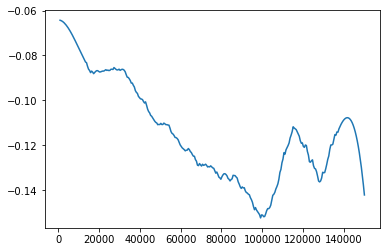

In [7]:

params = dict()
ws = np.linspace(1000,150000,300)
results = []
for i in range(len(ws)):
    print(ws[i])
    results.append(neg_mutual_info(w_longest_strike_above_mean, s, ttf, window_size = int(ws[i])))

plt.plot(ws,sg(results,51,3))

In [95]:
x0 = 150000
res = scipy.optimize.minimize(neg_mutual_info_mean, x0, method='Nelder-Mead', 
                              options = {'maxiter' : 100, 'disp': True, 'fatol' : 0.01, 'xatol' : 0.5})

w_longest_strike_above_mean(df, window_size=150000): 100%|██████████| 297/297 [00:40<00:00,  7.27it/s]
	 window decorator: 
	 - window size: 150000
w_last_elem(df, window_size=150000): 100%|██████████| 297/297 [00:00<00:00, 18797.19it/s]
	 window decorator: 
	 - window size: 150000
-0.1490288745534194
w_longest_strike_above_mean(df, window_size=157500):   0%|          | 1/283 [00:00<00:45,  6.18it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=157500): 100%|██████████| 283/283 [00:39<00:00,  7.08it/s]
	 window decorator: 
	 - window size: 157500
w_last_elem(df, window_size=157500): 100%|██████████| 283/283 [00:00<00:00, 19663.19it/s]
	 window decorator: 
	 - window size: 157500
-0.11175284432442378
w_longest_strike_above_mean(df, window_size=142500):   0%|          | 1/312 [00:00<00:46,  6.74it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=142500): 100%|██████████| 312/312 [00:39<00:00,  7.72it/s]
	 window decorator: 
	 - window size: 142500
w_last_elem(df, window_size=142500): 100%|██████████| 312/312 [00:00<00:00, 19985.99it/s]
	 window decorator: 
	 - window size: 142500
-0.1174984815447293
w_longest_strike_above_mean(df, window_size=146250):   0%|          | 1/304 [00:00<00:46,  6.58it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=146250): 100%|██████████| 304/304 [00:38<00:00,  7.62it/s]
	 window decorator: 
	 - window size: 146250
w_last_elem(df, window_size=146250): 100%|██████████| 304/304 [00:00<00:00, 20432.15it/s]
	 window decorator: 
	 - window size: 146250
-0.12102019045257517
w_longest_strike_above_mean(df, window_size=153750):   0%|          | 1/289 [00:00<00:46,  6.22it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=153750): 100%|██████████| 289/289 [00:39<00:00,  6.83it/s]
	 window decorator: 
	 - window size: 153750
w_last_elem(df, window_size=153750): 100%|██████████| 289/289 [00:00<00:00, 17452.11it/s]
	 window decorator: 
	 - window size: 153750
-0.10710530879796343
w_longest_strike_above_mean(df, window_size=148125):   0%|          | 1/300 [00:00<00:45,  6.58it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=148125): 100%|██████████| 300/300 [00:38<00:00,  7.18it/s]
	 window decorator: 
	 - window size: 148125
w_last_elem(df, window_size=148125): 100%|██████████| 300/300 [00:00<00:00, 20371.91it/s]
	 window decorator: 
	 - window size: 148125
-0.13676641192021055
w_longest_strike_above_mean(df, window_size=151875):   0%|          | 1/293 [00:00<00:44,  6.50it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151875): 100%|██████████| 293/293 [00:39<00:00,  7.42it/s]
	 window decorator: 
	 - window size: 151875
w_last_elem(df, window_size=151875): 100%|██████████| 293/293 [00:00<00:00, 19721.91it/s]
	 window decorator: 
	 - window size: 151875
-0.20227343296884248
w_longest_strike_above_mean(df, window_size=153750):   0%|          | 1/289 [00:00<00:47,  6.08it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=153750): 100%|██████████| 289/289 [00:39<00:00,  6.83it/s]
	 window decorator: 
	 - window size: 153750
w_last_elem(df, window_size=153750): 100%|██████████| 289/289 [00:00<00:00, 20056.49it/s]
	 window decorator: 
	 - window size: 153750
-0.10421757656273645
w_longest_strike_above_mean(df, window_size=153750):   0%|          | 1/289 [00:00<00:45,  6.31it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=153750): 100%|██████████| 289/289 [00:39<00:00,  6.86it/s]
	 window decorator: 
	 - window size: 153750
w_last_elem(df, window_size=153750): 100%|██████████| 289/289 [00:00<00:00, 20526.19it/s]
	 window decorator: 
	 - window size: 153750
-0.10348866463638284
w_longest_strike_above_mean(df, window_size=150937):   0%|          | 1/295 [00:00<00:49,  5.93it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=150937): 100%|██████████| 295/295 [00:39<00:00,  7.49it/s]
	 window decorator: 
	 - window size: 150937
w_last_elem(df, window_size=150937): 100%|██████████| 295/295 [00:00<00:00, 18478.49it/s]
	 window decorator: 
	 - window size: 150937
-0.1303192071083794
w_longest_strike_above_mean(df, window_size=150937):   0%|          | 1/295 [00:00<00:45,  6.43it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=150937): 100%|██████████| 295/295 [00:38<00:00,  7.58it/s]
	 window decorator: 
	 - window size: 150937
w_last_elem(df, window_size=150937): 100%|██████████| 295/295 [00:00<00:00, 20353.00it/s]
	 window decorator: 
	 - window size: 150937
-0.12304585596715212
w_longest_strike_above_mean(df, window_size=152812):   0%|          | 1/291 [00:00<00:44,  6.50it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=152812): 100%|██████████| 291/291 [00:39<00:00,  7.27it/s]
	 window decorator: 
	 - window size: 152812
w_last_elem(df, window_size=152812): 100%|██████████| 291/291 [00:00<00:00, 17503.08it/s]
	 window decorator: 
	 - window size: 152812
-0.14194291665827485
w_longest_strike_above_mean(df, window_size=152343):   0%|          | 1/292 [00:00<00:46,  6.29it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=152343): 100%|██████████| 292/292 [00:39<00:00,  7.58it/s]
	 window decorator: 
	 - window size: 152343
w_last_elem(df, window_size=152343): 100%|██████████| 292/292 [00:00<00:00, 18405.75it/s]
	 window decorator: 
	 - window size: 152343
-0.13325761760446042
w_longest_strike_above_mean(df, window_size=151406):   0%|          | 1/294 [00:00<00:44,  6.59it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151406): 100%|██████████| 294/294 [00:38<00:00,  7.58it/s]
	 window decorator: 
	 - window size: 151406
w_last_elem(df, window_size=151406): 100%|██████████| 294/294 [00:00<00:00, 19924.47it/s]
	 window decorator: 
	 - window size: 151406
-0.11666274372467456
w_longest_strike_above_mean(df, window_size=152343):   0%|          | 1/292 [00:00<00:44,  6.50it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=152343): 100%|██████████| 292/292 [00:38<00:00,  7.56it/s]
	 window decorator: 
	 - window size: 152343
w_last_elem(df, window_size=152343): 100%|██████████| 292/292 [00:00<00:00, 19997.01it/s]
	 window decorator: 
	 - window size: 152343
-0.1289599605644831
w_longest_strike_above_mean(df, window_size=152109):   0%|          | 1/293 [00:00<00:44,  6.52it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=152109): 100%|██████████| 293/293 [00:39<00:00,  7.33it/s]
	 window decorator: 
	 - window size: 152109
w_last_elem(df, window_size=152109): 100%|██████████| 293/293 [00:00<00:00, 19883.04it/s]
	 window decorator: 
	 - window size: 152109
-0.13019951054965428
w_longest_strike_above_mean(df, window_size=151640):   0%|          | 1/293 [00:00<00:46,  6.25it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151640): 100%|██████████| 293/293 [00:38<00:00,  7.04it/s]
	 window decorator: 
	 - window size: 151640
w_last_elem(df, window_size=151640): 100%|██████████| 293/293 [00:00<00:00, 18369.12it/s]
	 window decorator: 
	 - window size: 151640
-0.13389430354765208
w_longest_strike_above_mean(df, window_size=151757):   0%|          | 1/293 [00:00<00:45,  6.46it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151757): 100%|██████████| 293/293 [00:39<00:00,  6.81it/s]
	 window decorator: 
	 - window size: 151757
w_last_elem(df, window_size=151757): 100%|██████████| 293/293 [00:00<00:00, 17276.77it/s]
	 window decorator: 
	 - window size: 151757
-0.1575443857828973
w_longest_strike_above_mean(df, window_size=151992):   0%|          | 1/293 [00:00<00:46,  6.32it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151992): 100%|██████████| 293/293 [00:40<00:00,  7.21it/s]
	 window decorator: 
	 - window size: 151992
w_last_elem(df, window_size=151992): 100%|██████████| 293/293 [00:00<00:00, 19149.39it/s]
	 window decorator: 
	 - window size: 151992
-0.14543257494218187
w_longest_strike_above_mean(df, window_size=151816):   0%|          | 1/293 [00:00<00:44,  6.58it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151816): 100%|██████████| 293/293 [00:40<00:00,  7.53it/s]
	 window decorator: 
	 - window size: 151816
w_last_elem(df, window_size=151816): 100%|██████████| 293/293 [00:00<00:00, 19228.19it/s]
	 window decorator: 
	 - window size: 151816
-0.19898060621171076
w_longest_strike_above_mean(df, window_size=151933):   0%|          | 1/293 [00:00<00:45,  6.43it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151933): 100%|██████████| 293/293 [00:39<00:00,  7.37it/s]
	 window decorator: 
	 - window size: 151933
w_last_elem(df, window_size=151933): 100%|██████████| 293/293 [00:00<00:00, 20430.09it/s]
	 window decorator: 
	 - window size: 151933
-0.1332887669706868
w_longest_strike_above_mean(df, window_size=151845):   0%|          | 1/293 [00:00<00:44,  6.53it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151845): 100%|██████████| 293/293 [00:40<00:00,  7.17it/s]
	 window decorator: 
	 - window size: 151845
w_last_elem(df, window_size=151845): 100%|██████████| 293/293 [00:00<00:00, 20086.48it/s]
	 window decorator: 
	 - window size: 151845
-0.18298876089362048
w_longest_strike_above_mean(df, window_size=151845):   0%|          | 1/293 [00:00<00:44,  6.56it/s]

/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pavel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


w_longest_strike_above_mean(df, window_size=151845):  44%|████▎     | 128/293 [00:18<00:23,  7.01it/s]

KeyboardInterrupt: 

In [92]:
print(res)

 final_simplex: (array([[149815.52124023],
       [149815.97900391]]), array([-0.61311473, -0.61266083]))
           fun: -0.6131147289233763
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 16
        status: 0
       success: True
             x: array([149815.52124023])
